# auto reload

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import

In [137]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
# from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Make dataset class

In [3]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, annotation_path, img_dir, img_size): # name2idx is encode classname as int, name2idx is encoder.
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.img_size = img_size
        self.name2idx = None
        self.img_data_all,  self.gt_classes_all, self.gt_bboxes_all = self.get_data()

    def __len__(self):
        return len(self.img_data_all)
    
    def __getitem__(self, index):
        return self.img_data_all[index], self.gt_bboxes_all[index], self.gt_classes_all[index]
    
    def scale_bounding_box(self, scale_width, scale_height, boxes_img_raw):
        boxes_img = [[float(i[ind] * scale_width) if ind % 2 == 0 else float(i[ind] * scale_height)
                                   for ind in range(len(i))] for i in boxes_img_raw]
        return boxes_img

    def get_data(self):
        img_data_all = []
        gt_idxs_all = []
        boxes_all_scale = []
        img_paths, gt_classes_all, gt_boxes_all = parse_annotation(self.annotation_path, self.img_dir) # function from utils.py
        '''
        img_paths: [path1, path2, path3,...]
        gt_class_all: [[class1, class2,..], [class2,..], [class1, class3,..],...]
        gt_boxes_all: [[[x_min, y_min, x_max, y_max], [x_min, y_min, x_max, y_max],...],... ]
        '''
        for index, img_path in enumerate(img_paths):
            if (not img_path) or (not os.path.exists(img_path)):
                continue
            image = io.imread(img_path) # width, height, chanel
            old_width = image.shape[1]
            old_height = image.shape[0]
            # resize
            image = resize(image, self.img_size)

            # after resize image, we need to adjust bounding box data to fit the new image
            boxes_img_scale = self.scale_bounding_box(self.img_size[1]/old_width,
                                                      self.img_size[0]/old_height,
                                                      gt_boxes_all[index])
            boxes_all_scale.append(torch.Tensor(boxes_img_scale))

            # convert to tensor and reshape chanel, width, height
            image = torch.from_numpy(image).permute(2,0,1)
            img_data_all.append(image)

            #encode class name
            self.name2idx = encode_class(gt_classes_all) # make dictionary of class and index of it {'class': index}
            gt_idxs_all.append(torch.Tensor([self.name2idx[class_name]
                                             for class_name in gt_classes_all[index]]))

        #padding bounding box and classes so that elements within (bên trong) them are the same size
        gt_idxs_all_padded = pad_sequence(gt_idxs_all, batch_first= True, padding_value=-1) # batch_first=True -> Batch, maxlenght, dim
        gt_boxes_all_padded = pad_sequence(boxes_all_scale, batch_first=True, padding_value=-1) # nếu batch_first=False -> maxlenght, batch, dim
        
        #stack all image to a Tensor
        imgs_stack = torch.stack(img_data_all, dim=0)
        # dữ liệu ở float32 sẽ đỡ tốn bộ nhớ hơn dữ liệu ở float64(default)
        return imgs_stack.to(dtype=torch.float32), gt_idxs_all_padded, gt_boxes_all_padded

In [4]:
annotations_path = "VOCdevkit/VOC2007/Annotations"
img_size = (200, 200)
img_dir = "VOCdevkit/VOC2007/JPEGImages"

# Create dataset and dataloader

## Dataset

In [5]:
dataset = ObjectDetectionDataset(annotations_path, img_dir, img_size)

- All class and it's index

In [7]:
idx2name = decode_class(dataset.name2idx)
idx2name.update({-1: ''})

## dataset example

In [9]:
dataset.__getitem__(0)

(tensor([[[0.0383, 0.0413, 0.0413,  ..., 0.6515, 0.6428, 0.6372],
          [0.2125, 0.1444, 0.0865,  ..., 0.6474, 0.6458, 0.6457],
          [0.3854, 0.3963, 0.4180,  ..., 0.6618, 0.6588, 0.6544],
          ...,
          [0.0838, 0.0793, 0.0902,  ..., 0.2995, 0.2785, 0.2416],
          [0.1096, 0.1198, 0.2132,  ..., 0.2639, 0.2317, 0.2302],
          [0.1875, 0.2816, 0.2998,  ..., 0.2324, 0.2344, 0.2669]],
 
         [[0.0410, 0.0431, 0.0524,  ..., 0.7367, 0.7359, 0.7352],
          [0.2329, 0.1527, 0.0865,  ..., 0.7560, 0.7473, 0.7436],
          [0.4492, 0.4681, 0.4853,  ..., 0.7606, 0.7546, 0.7460],
          ...,
          [0.0392, 0.0295, 0.0198,  ..., 0.3528, 0.3150, 0.2746],
          [0.0448, 0.0324, 0.0612,  ..., 0.3150, 0.2818, 0.2750],
          [0.0588, 0.0986, 0.0872,  ..., 0.2785, 0.2931, 0.3222]],
 
         [[0.0420, 0.0416, 0.0429,  ..., 0.7667, 0.7630, 0.7627],
          [0.2418, 0.1634, 0.0962,  ..., 0.7760, 0.7720, 0.7709],
          [0.4607, 0.4769, 0.4937,  ...,

In [10]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 200, 200])

In [11]:
dataset.__getitem__(0)[1]

tensor([[ 66.0000, 140.8000, 101.2000, 198.4000],
        [  2.0000, 130.1333,  26.8000, 199.4667],
        [ 96.4000, 103.4667, 118.0000, 159.4667],
        [110.8000,  99.2000, 124.8000, 117.3333],
        [110.8000,  99.2000, 124.8000, 117.3333],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],
        [ -1.0000,  -1.0000,  -1.0000,  -1.0000],


(<Figure size 1000x500 with 2 Axes>, <Axes: >)

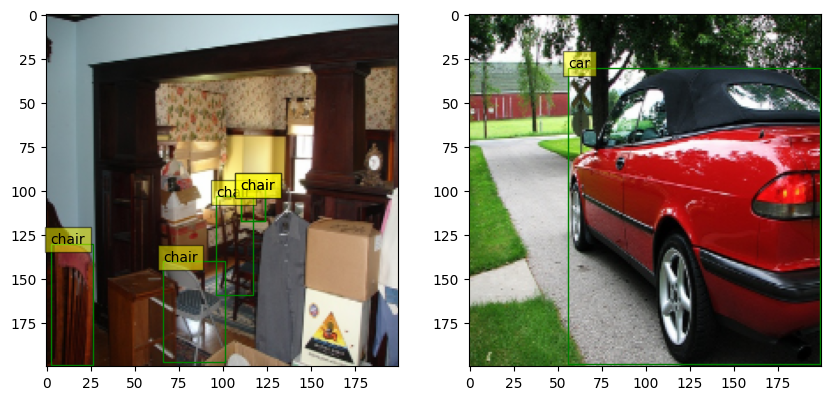

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
display_img([dataset.__getitem__(0)[0], dataset.__getitem__(1)[0]], fig, ax)
display_boundingbox(dataset.__getitem__(0)[1], [idx2name[int(i)] for i in dataset.__getitem__(0)[2]], fig, ax[0])
display_boundingbox(dataset.__getitem__(1)[1], [idx2name[int(i)] for i in dataset.__getitem__(1)[2]], fig, ax[1])

### Visualize image and bounding box for all class of some sample

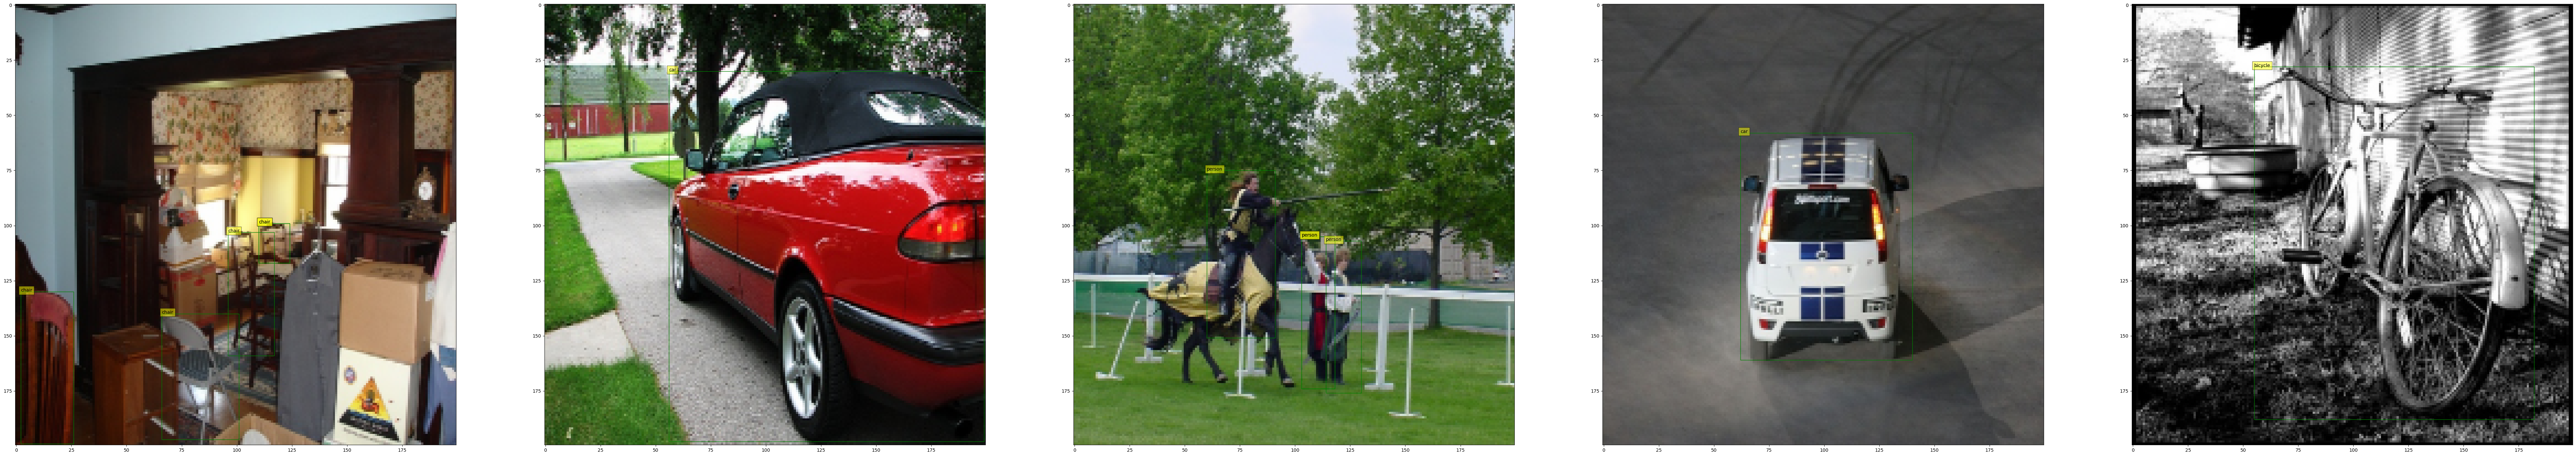

In [12]:
count_tesst = 0
fig, ax = plt.subplots(1, 5 , figsize=(100, 20))
display_img([dataset.__getitem__(index)[0] for index in range(5)], fig, ax)
for index in range(5):
    _, gt_boxes_data, gt_classes_data = dataset.__getitem__(index)
    display_boundingbox(gt_boxes_data, [idx2name[int(i)] for i in gt_classes_data], fig, ax[index])
    count_tesst +=1
    if count_tesst == 6:
        break

## DataLoader

In [8]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# CNN Backbone

- Cho ảnh qua CNN để lấy feature map, chiều của feature map sẽ nhỏ hơn chiều ảnh

In [9]:
from torchvision.models import vgg16, VGG16_Weights
model = vgg16(weights =  VGG16_Weights)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
feature_extractor = torch.nn.Sequential(*list(model.children())[0][:17])

## Visualize example of output feature_extractor

### infomation of data ouput of feature_extractor

In [11]:
img_data_sample, gt_boxes_sample, gt_classes_sample = dataset.__getitem__(0)
feature_out = feature_extractor(img_data_sample)
feature_img_chanel, feature_img_height, feature_img_width = feature_out.shape[0], feature_out.shape[1], feature_out.shape[2]
print(feature_img_chanel, feature_img_height, feature_img_width)


256 25 25


### visualize

(<Figure size 2000x500 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

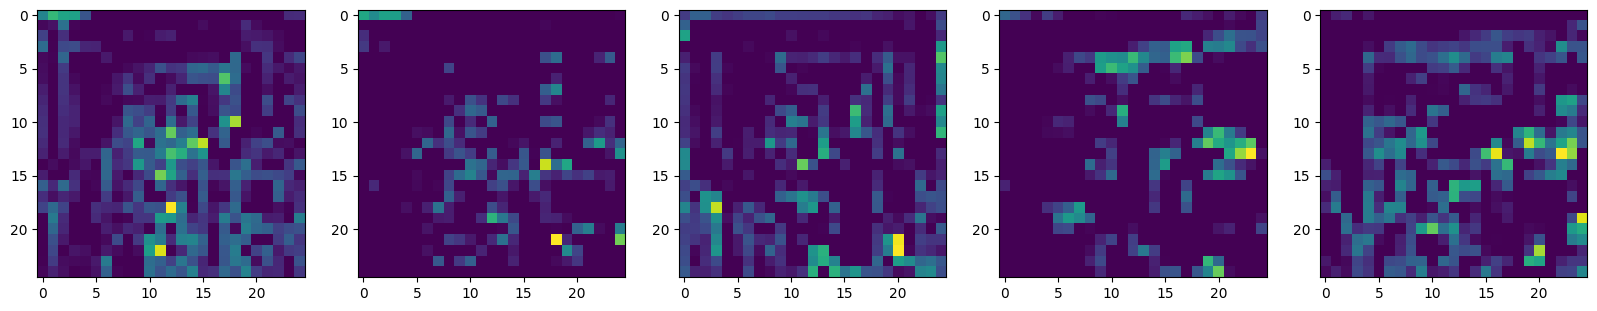

In [12]:
fig1, ax1 = plt.subplots(1, 5, figsize=(20, 5))
display_img([feature_out[i].detach().numpy() for i in range(5)], fig1, ax1)

# Grid Map

- vẽ ra các anchor (các điểm) ở ảnh đầu vào mà số anchor ở chiều rộng bằng width của ảnh feature map và số anchor ở chiều dài bằng height của ảnh feature map

In [13]:
scale_center = img_size[0]/feature_img_height
centers_x, centers_y = generate_anchor_centers((feature_img_height, feature_img_width), scale_center)
centers = [[x, y] for x in centers_x for y in centers_y]
print(len(centers))


625


- Lấy tất cả bboxes của các anchor (kể cả anchor box không hợp lệ)

In [14]:
all_bboxes = generate_all_anchor_boxes(centers, img_size[0]/feature_img_height)
all_bboxes_tensor = torch.stack(all_bboxes, dim=0)
all_bboxes_tensor.shape

torch.Size([625, 9, 4])

## display valid bboxes

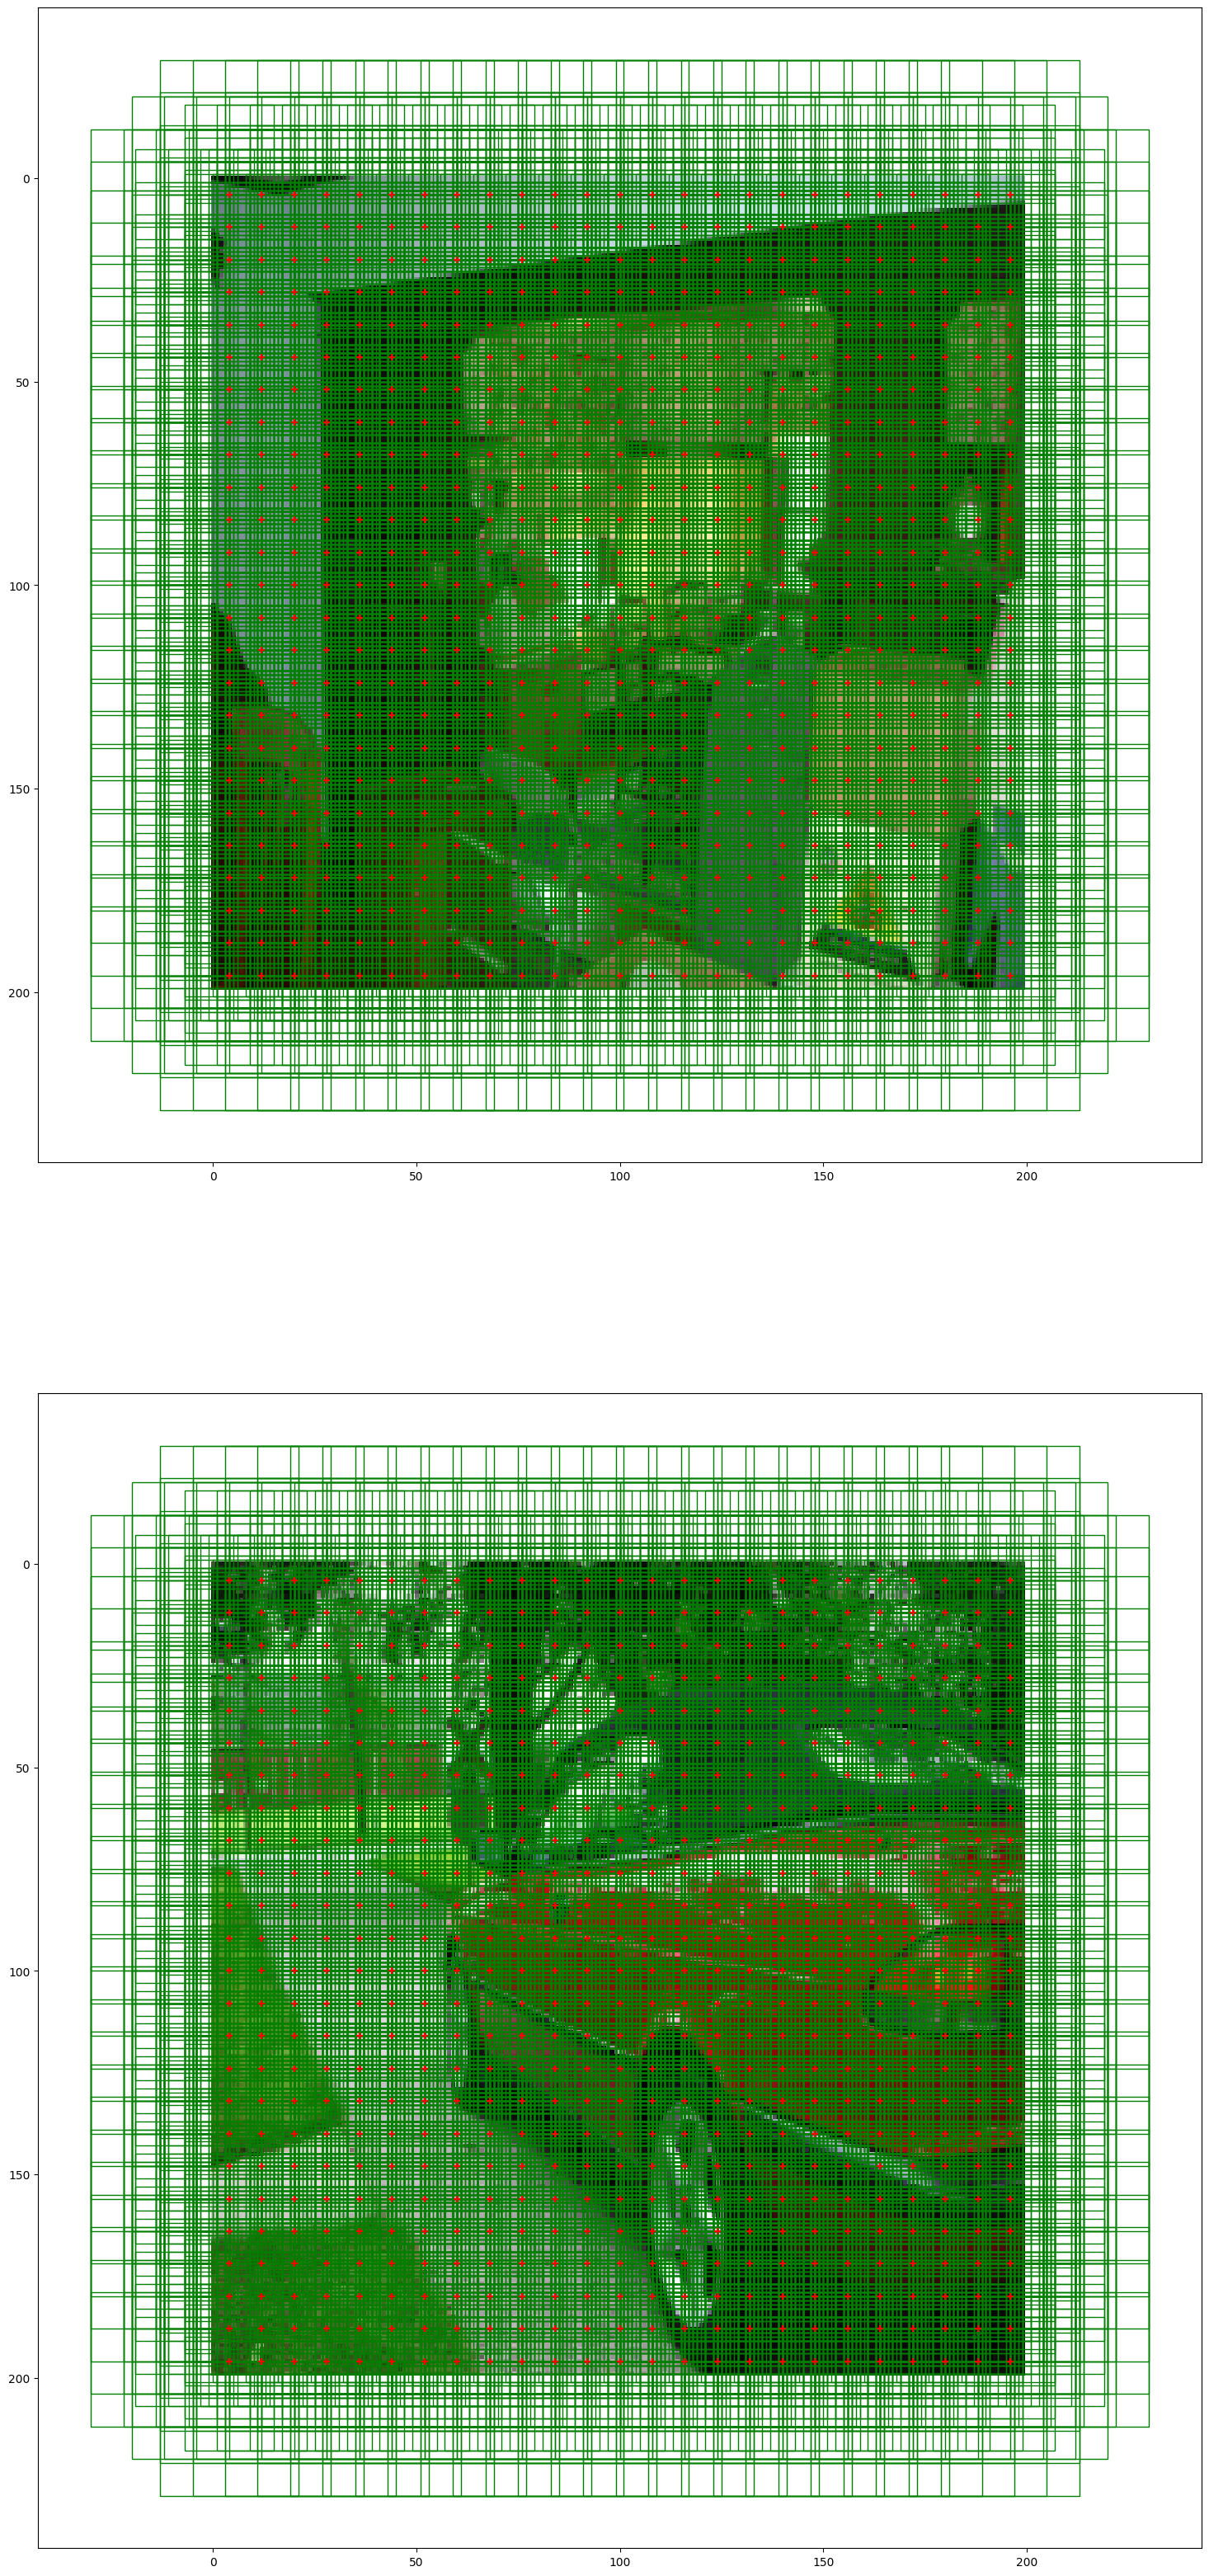

In [24]:
fig1, axes1 = plt.subplots(2, 1, figsize=(80,40))
display_img([dataset.__getitem__(index)[0] for index in range(2)], fig1, axes1)
for index in range(2):
    for bboxe in all_bboxes:
        bboxe = ops.box_convert(bboxe, in_fmt='xywh', out_fmt='xyxy')
        display_boundingbox(bboxe, ['' for i in range(bboxe.shape[0])], fig1, axes1[index])
    display_anchor_centers(centers_x, centers_y, fig1, axes1[index])
    display_anchor_centers(centers_x, centers_y, fig1, axes1[index])

## Assign a label and location

- lấy tất cả các location, iou, label tương ứng của all_bboxes

In [15]:
img_data_sample, gt_boxes_sample, gt_classes_sample = next(iter(dataloader))

In [16]:
gt_boxes_sample.shape

torch.Size([1, 42, 4])

In [17]:
gt_appear_in_an_img = gt_boxes_sample[0][torch.where(gt_boxes_sample[0][:,0] != -1)[0]]

In [18]:
gt_appear_in_an_img.shape, gt_appear_in_an_img.unsqueeze(0).shape

(torch.Size([3, 4]), torch.Size([1, 3, 4]))

In [19]:
all_location_boxes, all_iou_boxes, all_label_boxes = calculate_location_iou_label(all_bboxes_tensor, gt_appear_in_an_img.unsqueeze(0))
'''
localtion_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...]) dim = 1 x N x 4 với N là số anchor boxes
iou_boxes: tensor([tensor[iou1, iou2,...],...]) dim = 1 x N X M với M là số ground truth boxes của ảnh
label_boxes: tensor([label1, label2,...]) dim = 1 x N
'''

'\nlocaltion_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...]) dim = 1 x N x 4 với N là số anchor boxes\niou_boxes: tensor([tensor[iou1, iou2,...],...]) dim = 1 x N X M với M là số ground truth boxes của ảnh\nlabel_boxes: tensor([label1, label2,...]) dim = 1 x N\n'

In [20]:
all_location_boxes.shape, all_iou_boxes.shape, all_label_boxes.shape

(torch.Size([1, 5625, 4]), torch.Size([1, 5625, 3]), torch.Size([1, 5625]))

# test workflow

- Với mỗi ground truth box trong ảnh, tìm ra box có iou cao nhất

In [21]:
gt_argmax_iou = all_iou_boxes[0].argmax(dim=0)
print(gt_argmax_iou)
print(gt_argmax_iou.shape)
gt_max_iou = all_iou_boxes[0][gt_argmax_iou, torch.arange(gt_argmax_iou.shape[0])]
print(gt_max_iou)
print(gt_max_iou.shape)


tensor([2805, 5463, 5463])
torch.Size([3])
tensor([0.4319, 0.4677, 0.4677])
torch.Size([3])


In [22]:
gt_max_iou 

tensor([0.4319, 0.4677, 0.4677])

- Tìm những anchor box có điểm iou với gt tương ứng = gt_max_iou tương ứng

In [23]:
gt_max_iou.shape

torch.Size([3])

In [24]:
gt_argmax_iou = torch.where(all_iou_boxes[0] == gt_max_iou)[0]
print(gt_argmax_iou)
print(gt_argmax_iou.shape)

tensor([2805, 2814, 2823, 2832, 2841, 2850, 2859, 2868, 5463, 5463, 5472, 5472])
torch.Size([12])


In [25]:
all_location_boxes[0][gt_argmax_iou].shape

torch.Size([12, 4])

-  Với mỗi anchor box trong ảnh, tìm xem anchor đó có điểm iou cao nhất với ground truth box nào

In [26]:
anchor_boxes_argmax_iou = all_iou_boxes[0].argmax(dim=1)
print(anchor_boxes_argmax_iou.shape)
print(anchor_boxes_argmax_iou)
anchor_boxes_max_iou = all_iou_boxes[0][torch.arange(all_iou_boxes[0].shape[0]), anchor_boxes_argmax_iou]
print(anchor_boxes_max_iou)
print(anchor_boxes_max_iou.shape)

torch.Size([5625])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([5625])


In [27]:
anchor_boxes_max_iou[anchor_boxes_max_iou > 0.7]

tensor([])

- Với mỗi anchor box, lấy chỉ số của ground truth box mà có điểm iou cao nhất với anchor box đó

In [32]:
gt_appear_in_an_img

tensor([[ 88.4000,  53.7143, 113.2000, 184.0000],
        [192.8000,  48.0000, 200.0000,  83.4286],
        [192.8000,  48.0000, 200.0000,  83.4286]])

In [33]:
anchor_boxes_max_iou_coordinates = torch.stack([gt_appear_in_an_img[i] for i in anchor_boxes_argmax_iou])

In [34]:
print(anchor_boxes_max_iou_coordinates.shape)
anchor_boxes_max_iou_coordinates

torch.Size([5625, 4])


tensor([[ 88.4000,  53.7143, 113.2000, 184.0000],
        [ 88.4000,  53.7143, 113.2000, 184.0000],
        [ 88.4000,  53.7143, 113.2000, 184.0000],
        ...,
        [ 88.4000,  53.7143, 113.2000, 184.0000],
        [ 88.4000,  53.7143, 113.2000, 184.0000],
        [ 88.4000,  53.7143, 113.2000, 184.0000]])

In [45]:
a = torch.Tensor([[1,2,3],
                  [3,4,0],
                  [0,0,0],
                  [1,2,3]])
b = torch.Tensor([3,4,0])
torch.where(a == b)

(tensor([1, 1, 1, 2]), tensor([0, 1, 2, 2]))

- gán nhãn pos và neg
- anchor box nào không phải pos và cũng không phải neg thì không dùng để train

In [35]:
pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

In [36]:
all_label_boxes[0][anchor_boxes_max_iou < neg_iou_threshold] = 0
all_label_boxes[0][gt_argmax_iou] = 1
all_label_boxes[0][anchor_boxes_max_iou > pos_iou_threshold] = 1

- Lấy khoảng 1/10 số anchor hợp lệ trong 1 ảnh để tính loss function cho mini-batch

In [37]:
pos_ratio = 0.5
power_of_10 = 0
# while math.pow(10, power_of_10) <= len(location_boxes):
#     power_of_10 += 1
# n_sample = int((len(location_boxes)//math.pow(10,power_of_10 - 1))*math.pow(10,power_of_10 - 2))
n_sample = 64
n_pos = int(n_sample*pos_ratio)
n_pos

32

In [38]:
pos_index = torch.where(all_label_boxes[0] == 1)[0]
if len(pos_index) > n_pos:
    disable_index = torch.randperm(len(pos_index))[n_pos:]
    all_label_boxes[0][pos_index[disable_index]] = -1
pos_index = torch.where(all_label_boxes[0] == 1)[0]

In [39]:
n_neg = n_sample - len(torch.where(all_label_boxes[0] == 1)[0])
neg_index = torch.where(all_label_boxes[0] == 0)[0]
if len(neg_index) > n_neg:
    disable_index = torch.randperm(len(neg_index))[n_neg:]
    all_label_boxes[0][neg_index[disable_index]] = -1
neg_index = torch.where(all_label_boxes[0] == 0)[0]

In [40]:
n_neg

54

In [42]:
all_location_boxes[0][pos_index] == all_location_boxes[0][all_label_boxes[0] == 1]

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

- visualize pos_boxes and neg_boxes sample

(<Figure size 3000x1500 with 2 Axes>, <Axes: >)

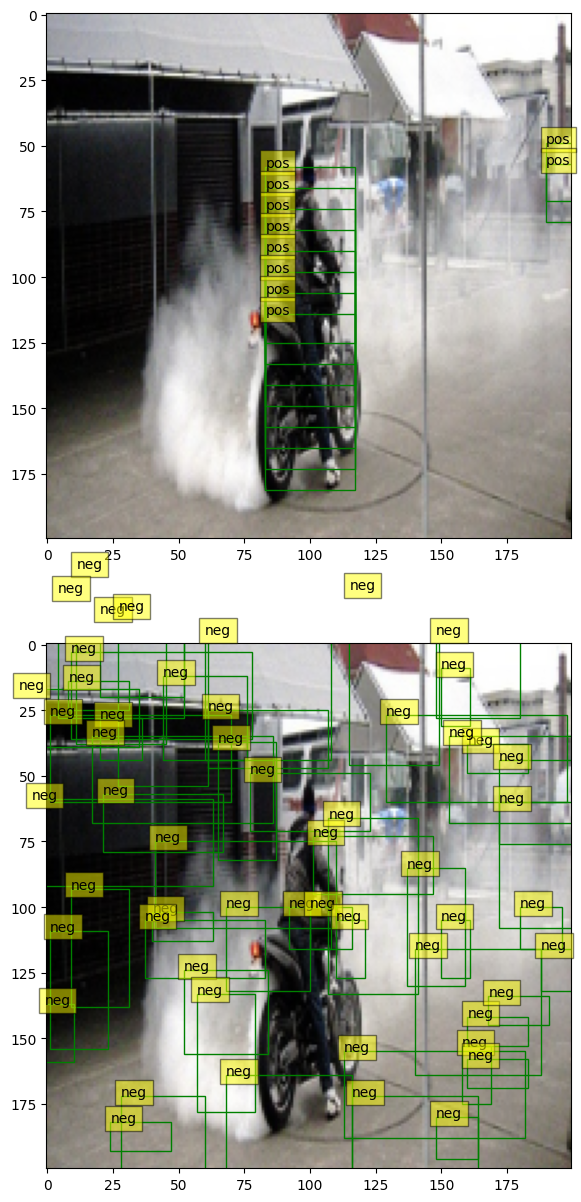

In [41]:
fig2, axes2 = plt.subplots(2, 1, figsize=(30, 15))
display_img([img_data_sample[0] , img_data_sample[0]], fig2, axes2)
bboxes_pos_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 1], in_fmt='xywh', out_fmt='xyxy')
display_boundingbox(bboxes_pos_xyxy, ['pos' for i in range(all_location_boxes[0][all_label_boxes[0] == 1].shape[0])], fig2, axes2[0])
bboxes_neg_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 0], in_fmt='xywh', out_fmt='xyxy')
display_boundingbox(bboxes_neg_xyxy, ['neg' for i in range(all_location_boxes[0][all_label_boxes[0] == 0].shape[0])], fig2, axes2[1])

- Mô hình cần học một bộ offsets để điều chỉnh anchorboxes sao cho gần nhất với gt_box, bộ offsets gồm:
    + t_x, t_y biểu diễn độ dịch chuyển của tâm anchor theo trục x, y
    + t_w, t_h biểu diễn tỷ lệ thay đổi về kích thước của anchor box so với gt box
    + log được dùng để cho mạng dễ học hơn
tránh dự đoán giá trị bbox ở phạm vi quá lớn dẫn đến khó tối ưu hóa

- convert coordinates anchor box từ x_top_left, y_top_left, w, h về x_center, y center, w, h để tính 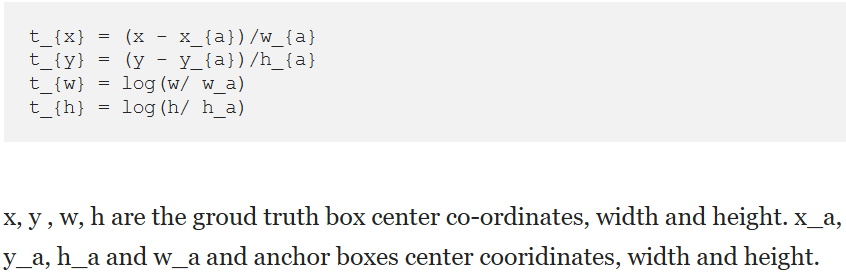

In [54]:
width_anchor_boxes = all_location_boxes[0][:,2] # size = torch.size([N]) với N là số anchor boxes 
height_anchor_boxes = all_location_boxes[0][:,3]
centers_x = all_location_boxes[0][:,0] + width_anchor_boxes/2
centers_y = all_location_boxes[0][:,1] + height_anchor_boxes/2

width_gt_boxes_anchor = anchor_boxes_max_iou_coordinates[:,2]
height_gt_boxes_anchor = anchor_boxes_max_iou_coordinates[:,3]
centers_x_gt = anchor_boxes_max_iou_coordinates[:,0] + width_gt_boxes_anchor/2
centers_y_gt = anchor_boxes_max_iou_coordinates[:,1] + height_gt_boxes_anchor/2


- Chỉnh sửa để width và height > 0 để tránh trường hợp chia cho 0 trong công thức

In [55]:
eps = torch.finfo(width_anchor_boxes.dtype).eps
width_anchor_boxes = torch.clamp_min(width_anchor_boxes, eps) # clamp_min: giữ giá trị nhỏ nhất là eps, tránh = 0
height_anchor_boxes = torch.clamp_min(height_anchor_boxes, eps)

In [56]:
ty = (centers_y_gt - centers_y) / height_anchor_boxes
tx = (centers_x_gt - centers_x) / width_anchor_boxes
th = torch.log(height_gt_boxes_anchor / height_anchor_boxes)
tw = torch.log(width_gt_boxes_anchor / width_anchor_boxes)
anchor_locations = torch.stack([tx, ty, tw, th], dim=1)
print(anchor_locations.shape)
anchor_locations

torch.Size([5625, 4])


tensor([[16.6818,  2.0848,  2.4541,  0.5978],
        [11.5000,  2.8667,  2.0794,  0.9163],
        [ 7.9783,  4.1242,  1.7165,  1.2910],
        ...,
        [-0.2353, -2.1736,  1.3257, -0.5158],
        [-0.1667, -3.0444,  0.9808, -0.1823],
        [-0.1087, -4.4131,  0.6179,  0.1924]])

In [57]:
anchor_labels = all_label_boxes

# Region proposal network

## Proposal Module

In [118]:
class ProposalModule(nn.Module):
    def __init__(self):
        super(ProposalModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # 256x25x25 -> 256x25x25
        self.cls_logist = nn.Conv2d(in_channels=256, out_channels=9*2, kernel_size=1, stride=1, padding=0) # 256x25x25 -> 18x25x25
        self.bbox_reg = nn.Conv2d(in_channels=256, out_channels=9*4, kernel_size=1, stride=1, padding=0) # 256x25x25 -> 36x25x25
        
    def forward(self, feature_map, positive_anchorbox_index=None, negative_anchorbox_index=None, positive_anchorbox_coordinates=None):
        x = self.conv1(feature_map)
        cls_logist = self.cls_logist(x)
        bbox_reg = self.bbox_reg(x)
        mode = 'train'
        if positive_anchorbox_index is None or negative_anchorbox_index is None or positive_anchorbox_coordinates is None:
            mode = 'eval'
        if mode == 'eval':
            return cls_logist, bbox_reg
        # get logist score of positive and negative anchor boxes
        cls_logist_pos = cls_logist.contiguous().view(-1, 2)[positive_anchorbox_index]
        cls_logist_neg = cls_logist.contiguous().view(-1, 2)[negative_anchorbox_index]

        # get offsets for positive anchor boxes
        offsets_pos = bbox_reg.contiguous().view(-1, 4)[positive_anchorbox_index]
        # generate proposal boxes
        proposals = generate_proposals(positive_anchorbox_coordinates, offsets_pos)

        return cls_logist_pos, cls_logist_neg, offsets_pos, proposals

        

### test module

In [175]:
PN = ProposalModule()
# init layer conv1 with zero mean and 0.01 standard deviation for weights and 0 for bias
PN.conv1.weight.data.normal_(0, 0.01)
PN.conv1.bias.data.zero_()
PN.cls_logist.weight.data.normal_(0, 0.01)
PN.cls_logist.bias.data.zero_()
PN.bbox_reg.weight.data.normal_(0, 0.01)
PN.bbox_reg.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
feature_test = feature_out.unsqueeze(0)
pos_score, neg_score, offset_pos, proposal = PN(feature_test, pos_index, neg_index, bboxes_pos_xyxy)
pos_score.shape, neg_score.shape, offset_pos.shape, proposal.shape

(torch.Size([10, 2]),
 torch.Size([54, 2]),
 torch.Size([10, 4]),
 torch.Size([10, 4]))

In [45]:
proposal

tensor([[ 80.7455,  68.9357, 113.6711, 131.7585],
        [ 81.1813,  59.3155, 111.4329, 117.7995],
        [ 90.0099,  86.3387, 131.2056, 171.8199],
        [ 94.0496,  94.8643, 135.1135, 169.1343],
        [ 93.1630, 115.4785, 139.7031, 186.6636],
        [ 76.7360,  90.3756, 105.8669, 159.8073],
        [ 76.8350, 110.7110, 114.1423, 178.7416],
        [ 93.1543, 125.0169, 134.4847, 181.3954],
        [190.8748,  50.7009, 205.2908,  76.9639],
        [189.4128,  56.9379, 200.6602,  80.2636]], grad_fn=<StackBackward0>)

## RegionProposalNetwork

In [138]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, feature_extractor, proposal_module):
        super(RegionProposalNetwork, self).__init__()
        self.feature_extractor = feature_extractor
        self.proposal_module = proposal_module
        self.pos_threshold = 0.7
        self.neg_threshold = 0.2
        self.n_sample = 64
        self.pos_ratio = 0.5

        # weights for loss
        self.w_conf = 1
        self.w_reg = 5

    def forward(self, img_data, gt_boxes, gt_classes):
        '''
        input:
            img_data: tensor([1, chanel, width, height])
            gt_boxes: tensor([1, len_gt_boxes, 4])
            gt_classes: tensor([1, len_gt_boxes])
        '''
        feature_map = self.feature_extractor(img_data)

        # generate anchors
        _, _, feature_width, feature_height = feature_map.shape
        scale_center = img_data.shape[2]/feature_width
        centers_x, centers_y = generate_anchor_centers((feature_height, feature_width), scale_center)
        centers = [[x, y] for x in centers_x for y in centers_y]
        # generate anchor boxes
        all_bboxes = generate_all_anchor_boxes(centers, scale_center)
        all_bboxes_tensor = torch.stack(all_bboxes, dim=0)
        # calculate location, iou, label
        gt_appear_in_an_img = gt_boxes[0][torch.where(gt_boxes[0][:,0] != -1)[0]]
        all_location_boxes, all_iou_boxes, \
            all_label_boxes = calculate_location_iou_label(all_bboxes_tensor, gt_appear_in_an_img.unsqueeze(0))
        '''
        all_location_boxes: tensor([tensor[x_top_left, y_top_left, dw, dh],...])
        dim = batch x N x 4 với N là số anchor boxes

        all_iou_boxes: tensor([tensor[iou1, iou2,...],...])
        dim = batch x N X M với M là số ground truth boxes của ảnh

        all_label_boxes: tensor([label1, label2,...])
        dim = batch x N
        '''
        
        # với mỗi ground truth box tìm anchor box có iou lớn nhất
        gt_argmax_iou = all_iou_boxes[0].argmax(dim=0)
        gt_max_iou = all_iou_boxes[0][gt_argmax_iou,
                                      torch.arange(gt_argmax_iou.shape[0])]
        
        # Tìm những anchor box có điểm iou tương ứng = gt_max_iou tương ứng
        gt_argmax_iou = torch.where(all_iou_boxes[0] == gt_max_iou)[0]

        # Với mỗi anchor box trong ảnh, tìm xem anchor box đó có điểm iou cao nhất với ground truth box nào
        anchor_boxes_argmax_iou = all_iou_boxes[0].argmax(dim=1)
        anchor_boxes_max_iou = all_iou_boxes[0][torch.arange(
            all_iou_boxes[0].shape[0]), anchor_boxes_argmax_iou]
        
        # Với mỗi anchor box, lấy chỉ số của ground truth box có iou lớn nhất với anchor box đó
        anchor_boxes_max_iou_coordinates = torch.stack([gt_appear_in_an_img[i] for i in anchor_boxes_argmax_iou])
        # Lấy nhãn cho anchor box
        gt_classes_anc = gt_classes[0][torch.where(gt_classes[0][:] != -1)]
        gt_classes_img = torch.stack([gt_classes_anc[i] for i in anchor_boxes_argmax_iou])
        # gán nhãn pos và neg cho anchor box
        all_label_boxes[0][anchor_boxes_max_iou < self.neg_threshold] = 0
        all_label_boxes[0][gt_argmax_iou] = 1
        all_label_boxes[0][anchor_boxes_max_iou > self.pos_threshold] = 1

        # lấy n_sample anchor box
        n_pos = int(self.n_sample*self.pos_ratio)
        pos_index = torch.where(all_label_boxes[0] == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = torch.randperm(len(pos_index))[n_pos:]
            all_label_boxes[0][pos_index[disable_index]] = -1
        pos_index = torch.where(all_label_boxes[0] == 1)[0]

        n_neg = self.n_sample - len(torch.where(all_label_boxes[0] == 1)[0])
        neg_index = torch.where(all_label_boxes[0] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = torch.randperm(len(neg_index))[n_neg:]
            all_label_boxes[0][neg_index[disable_index]] = -1
        neg_index = torch.where(all_label_boxes[0] == 0)[0]

        # tính toán offset cho anchor box
        bboxes_pos_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 1], in_fmt='xywh', out_fmt='xyxy')
        bboxes_neg_xyxy = ops.box_convert(all_location_boxes[0][all_label_boxes[0] == 0], in_fmt='xywh', out_fmt='xyxy')
        pos_score, neg_score, offset_pos, proposals = self.proposal_module(feature_map, pos_index, neg_index, bboxes_pos_xyxy)
        
        gt_offset = calc_gt_offset(bboxes_pos_xyxy, anchor_boxes_max_iou_coordinates[pos_index])
        cls_loss = calc_cls_loss(pos_score, neg_score)
        reg_loss = calc_bbox_reg_loss(gt_offset, offset_pos)

        total_rpn_loss = self.w_conf* cls_loss + self.w_reg*reg_loss

        return total_rpn_loss, feature_map, proposals, pos_index, gt_classes_img[pos_index]

        

## RegionProposalNetwork test

In [139]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        model = vgg16(weights = VGG16_Weights)
        required_layers = list(model.children())[0][:17]
        self.backbone = nn.Sequential(*required_layers)
        for param in self.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.backbone(x)

In [176]:
feature_extractor = FeatureExtractor()
RPN = RegionProposalNetwork(feature_extractor, PN)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
total_rpn_loss1, feature_map1, proposals1, pos_index1, gt_classes1 = RPN(img_data_sample, gt_boxes_sample, gt_classes_sample)

In [53]:
total_rpn_loss1.shape, feature_map1.shape, proposals1.shape, pos_index1.shape, gt_classes1.shape

(torch.Size([]),
 torch.Size([1, 256, 25, 25]),
 torch.Size([10, 4]),
 torch.Size([10]),
 torch.Size([10]))

In [56]:
proposal_test = proposals1.detach()/8
proposal_test.shape

torch.Size([10, 4])

In [48]:
proposal_test[0].unsqueeze(0).shape

torch.Size([1, 4])

- test classi module

In [49]:
len(idx2name)

21

In [ ]:
input_test = torch.Tensor([[5,5,5,5,5,5,5,5,5,5,5,5,5,5,14,5,5,5,5,5,5,5],[2,2,2,2,2,2,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]])
target_test = torch.Tensor([14,6])
F.cross_entropy(input_test, target_test.long())

tensor(1.5468)

- fix bug die kernel

In [ ]:
# feature_map1_test = torch.empty((1,256,25,25)).uniform_(0, 255)
# feature_map1_test.shape

torch.Size([1, 256, 25, 25])

In [ ]:
# proposal_test = torch.randint(0, 25, (5, 4)).float()
# proposal_test.shape

torch.Size([5, 4])

In [ ]:
# ops.roi_pool(feature_map1_test, [proposal_test], (2,2)).shape # bỏ proposal vào list để xử lý nhiều proposal trong 1 feature map

torch.Size([5, 256, 2, 2])

In [57]:
avg_pool_test = nn.AvgPool2d((2,2))
fc_test = nn.Linear(256,256)
cls_test = nn.Linear(256, len(idx2name))
roi_out_test = ops.roi_pool(feature_map1, [proposal_test], (2,2))
roi_out_test1  = avg_pool_test(roi_out_test)

In [58]:
roi_out_test1.shape

torch.Size([10, 256, 1, 1])

# Classification module

In [177]:
class ClassificationModule(nn.Module):
    def __init__(self, n_classes, roi_size, hidden_dim=256, feature_chanels=256):
        super(ClassificationModule, self).__init__()
        self.roi_size = roi_size
        self.avg_pool = nn.AvgPool2d(kernel_size=self.roi_size)
        self.fc = nn.Linear(feature_chanels, hidden_dim)
        self.cls_head = nn.Linear(hidden_dim, n_classes)
    def forward(self, feature_map, proposal_tensor_pos, gt_classes=None, img_size=(200,200)):
        '''
        gt_classes size: tensor([number of ground truth boxes])
        '''
        mode = 'train'
        if gt_classes is None:
            mode = 'eval'
        scale_img_feature = img_size[0]/feature_map.shape[2]
        proposal_feature_map = proposal_tensor_pos.detach()/scale_img_feature # size = N x 4 với N là số proposal
        proposal_feature_map = ops.clip_boxes_to_image(proposal_feature_map, (feature_map.shape[3], feature_map.shape[2]))
        # vì các proposal region có kích thước khác nhau nên cần resize về cùng kích thước để tính toán.
        roi_out = ops.roi_pool(feature_map, [proposal_feature_map.to(feature_map.device)], self.roi_size)
        '''
        roi_out: tensor([N, C, roi_size, roi_size]) với N là số proposal, C là số chanel của feature map
        '''
        roi_out = self.avg_pool(roi_out)

        #flatten output
        roi_out = roi_out.squeeze(-1).squeeze(-1)

        # pass roi_out through fully connected layer
        out = F.relu(self.fc(roi_out)) 

        # get the classification score
        cls_score = self.cls_head(out)

        if mode == 'eval':
            return cls_score
        
        # compute cross entropy loss
        cls_loss = F.cross_entropy(cls_score, gt_classes.long())
        return cls_loss

- test Classification Module

In [178]:
classifier = ClassificationModule(len(idx2name), (7,7))

In [72]:
proposal_ftm = classifier(feature_map1, proposals1, gt_classes1)

In [73]:
proposal_ftm

tensor(4.9558, grad_fn=<NllLossBackward0>)

# Two stage detector

In [179]:
class TwoStageDetector(nn.Module):
    def __init__(self, feature_extractor, proposal_module, n_classes, roi_size):
        super(TwoStageDetector, self).__init__()
        self.rpn = RegionProposalNetwork(feature_extractor, proposal_module)
        self.classifier = ClassificationModule(n_classes, roi_size)
    def forward(self, img_data, gt_boxes, gt_classes):
        rpn_loss, feature_map, proposals, pos_index, gt_classes = self.rpn(img_data, gt_boxes, gt_classes)
        classifier_loss = self.classifier(feature_map, proposals, gt_classes)
        total_loss = rpn_loss + classifier_loss
        return total_loss

- test module

In [180]:
two_stage_detector = TwoStageDetector(feature_extractor, PN, len(idx2name), (7,7))

In [ ]:
total_loss = two_stage_detector(img_data_sample, gt_boxes_sample, gt_classes_sample)
total_loss

tensor(101.1693, grad_fn=<AddBackward0>)

# trainning loop

In [78]:
from tqdm import tqdm

In [181]:
def training(model, dataloader, learning_rate, n_epoch, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_list = []
    for i in range(n_epoch):
        loss_o = 0
        for img_data, gt_boxes, gt_classes in tqdm(dataloader):

            img_data = img_data.to(device)
            gt_boxes = gt_boxes.to(device)
            gt_classes = gt_classes.to(device)
            model.to(device)
            loss = model(img_data, gt_boxes, gt_classes)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_o += loss.item()
            loss_list.append(loss.item())
            print(f'Epoch {i}, loss: {loss.item()}')
    return loss_list

In [182]:
learning_rate = 1e-3
n_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
loss_list = training(two_stage_detector, dataloader, learning_rate, n_epochs, device)

cuda


  0%|          | 1/5011 [00:08<11:37:28,  8.35s/it]

Epoch 0, loss: 98.13290405273438


  0%|          | 2/5011 [00:12<8:25:43,  6.06s/it] 

Epoch 0, loss: 139.704833984375


  0%|          | 3/5011 [00:16<7:04:36,  5.09s/it]

Epoch 0, loss: 181.45712280273438


  0%|          | 4/5011 [00:20<6:24:33,  4.61s/it]

Epoch 0, loss: 183.97134399414062


  0%|          | 5/5011 [00:32<9:50:36,  7.08s/it]

Epoch 0, loss: 109.06144714355469


  0%|          | 6/5011 [00:36<8:34:52,  6.17s/it]

Epoch 0, loss: 87.08016204833984


  0%|          | 7/5011 [00:43<9:06:00,  6.55s/it]

Epoch 0, loss: 160.0924072265625


  0%|          | 8/5011 [01:06<16:13:07, 11.67s/it]

Epoch 0, loss: 112.32723999023438


  0%|          | 9/5011 [01:10<12:55:41,  9.30s/it]

Epoch 0, loss: 134.52674865722656


  0%|          | 10/5011 [01:26<15:55:08, 11.46s/it]

Epoch 0, loss: 90.70130157470703


  0%|          | 11/5011 [01:46<19:28:53, 14.03s/it]

Epoch 0, loss: 96.75760650634766


  0%|          | 12/5011 [01:54<16:38:55, 11.99s/it]

Epoch 0, loss: 114.2525634765625


  0%|          | 13/5011 [03:30<52:02:52, 37.49s/it]

Epoch 0, loss: 105.43666076660156


  0%|          | 14/5011 [03:34<38:19:28, 27.61s/it]

Epoch 0, loss: 92.87275695800781


  0%|          | 15/5011 [03:43<30:23:32, 21.90s/it]

Epoch 0, loss: 89.1210708618164


  0%|          | 16/5011 [03:48<23:10:23, 16.70s/it]

Epoch 0, loss: 89.90316009521484


  0%|          | 17/5011 [04:07<24:21:12, 17.56s/it]

Epoch 0, loss: 115.26300811767578


  0%|          | 18/5011 [04:12<18:48:57, 13.57s/it]

Epoch 0, loss: 165.3733673095703


  0%|          | 19/5011 [04:16<14:59:34, 10.81s/it]

Epoch 0, loss: 128.01882934570312


  0%|          | 20/5011 [04:20<12:21:11,  8.91s/it]

Epoch 0, loss: 98.66022491455078


  0%|          | 21/5011 [04:25<10:36:25,  7.65s/it]

Epoch 0, loss: 97.79024505615234


  0%|          | 22/5011 [04:37<12:19:59,  8.90s/it]

Epoch 0, loss: 118.50688934326172


  0%|          | 23/5011 [05:09<21:59:19, 15.87s/it]

Epoch 0, loss: 97.746337890625


  0%|          | 24/5011 [05:17<18:39:44, 13.47s/it]

Epoch 0, loss: 102.5768814086914


  0%|          | 25/5011 [05:26<16:39:10, 12.02s/it]

Epoch 0, loss: 84.20764923095703


  1%|          | 26/5011 [05:34<15:14:05, 11.00s/it]

Epoch 0, loss: 84.79552459716797


  1%|          | 27/5011 [05:58<20:31:49, 14.83s/it]

Epoch 0, loss: 114.5976333618164


  1%|          | 28/5011 [06:46<34:24:48, 24.86s/it]

Epoch 0, loss: 85.20506286621094


  1%|          | 29/5011 [06:54<27:26:42, 19.83s/it]

Epoch 0, loss: 114.04046630859375


  1%|          | 30/5011 [07:11<25:59:37, 18.79s/it]

Epoch 0, loss: 79.08467864990234


  1%|          | 31/5011 [07:35<28:17:01, 20.45s/it]

Epoch 0, loss: 110.72962951660156


  1%|          | 32/5011 [07:40<21:45:04, 15.73s/it]

Epoch 0, loss: 111.14647674560547


  1%|          | 33/5011 [07:44<17:09:06, 12.40s/it]

Epoch 0, loss: 140.7877197265625


  1%|          | 34/5011 [07:49<13:49:52, 10.00s/it]

Epoch 0, loss: 139.06649780273438


  1%|          | 35/5011 [07:53<11:31:11,  8.33s/it]

Epoch 0, loss: 125.46360778808594


  1%|          | 36/5011 [08:05<13:07:11,  9.49s/it]

Epoch 0, loss: 84.40023040771484


  1%|          | 37/5011 [08:11<11:18:51,  8.19s/it]

Epoch 0, loss: 76.47117614746094


  1%|          | 38/5011 [08:19<11:28:59,  8.31s/it]

Epoch 0, loss: 70.13965606689453


  1%|          | 39/5011 [08:40<16:40:56, 12.08s/it]

Epoch 0, loss: 63.13761901855469


  1%|          | 40/5011 [08:44<13:24:06,  9.71s/it]

Epoch 0, loss: 72.1812973022461


  1%|          | 41/5011 [08:52<12:36:56,  9.14s/it]

Epoch 0, loss: 89.77561950683594


  1%|          | 42/5011 [09:26<22:41:26, 16.44s/it]

Epoch 0, loss: 96.10477447509766


  1%|          | 43/5011 [09:30<17:38:01, 12.78s/it]

Epoch 0, loss: 163.00975036621094


  1%|          | 44/5011 [09:41<16:50:51, 12.21s/it]

Epoch 0, loss: 129.70835876464844


  1%|          | 45/5011 [09:59<19:32:00, 14.16s/it]

Epoch 0, loss: 76.7238998413086


  1%|          | 46/5011 [10:07<16:45:06, 12.15s/it]

Epoch 0, loss: 144.78842163085938


  1%|          | 47/5011 [10:11<13:19:10,  9.66s/it]

Epoch 0, loss: 174.95347595214844


  1%|          | 48/5011 [10:25<15:21:55, 11.15s/it]

Epoch 0, loss: 114.13230895996094


  1%|          | 49/5011 [10:33<13:47:14, 10.00s/it]

Epoch 0, loss: 136.3497772216797


  1%|          | 50/5011 [10:41<13:07:38,  9.53s/it]

Epoch 0, loss: 82.00865936279297


  1%|          | 51/5011 [10:46<11:02:46,  8.02s/it]

Epoch 0, loss: 108.16175079345703


  1%|          | 52/5011 [10:57<12:29:49,  9.07s/it]

Epoch 0, loss: 155.35739135742188


  1%|          | 53/5011 [11:10<13:58:03, 10.14s/it]

Epoch 0, loss: 71.66389465332031


  1%|          | 54/5011 [11:14<11:29:24,  8.34s/it]

Epoch 0, loss: 249.50973510742188


  1%|          | 55/5011 [11:22<11:31:32,  8.37s/it]

Epoch 0, loss: 107.04047393798828


  1%|          | 56/5011 [11:38<14:45:21, 10.72s/it]

Epoch 0, loss: 127.71843719482422


  1%|          | 57/5011 [11:42<11:58:05,  8.70s/it]

Epoch 0, loss: 167.40972900390625


  1%|          | 58/5011 [11:58<14:39:44, 10.66s/it]

Epoch 0, loss: 76.5422134399414


  1%|          | 59/5011 [12:20<19:20:50, 14.07s/it]

Epoch 0, loss: 126.65625


  1%|          | 60/5011 [12:27<16:41:47, 12.14s/it]

Epoch 0, loss: 118.20497131347656


  1%|          | 61/5011 [12:31<13:17:19,  9.66s/it]

Epoch 0, loss: 171.51889038085938


  1%|          | 62/5011 [12:35<11:01:47,  8.02s/it]

Epoch 0, loss: 146.34715270996094


  1%|▏         | 63/5011 [12:43<10:47:27,  7.85s/it]

Epoch 0, loss: 122.29044342041016


  1%|▏         | 64/5011 [13:02<15:19:36, 11.15s/it]

Epoch 0, loss: 73.17586517333984


  1%|▏         | 65/5011 [13:28<21:38:11, 15.75s/it]

Epoch 0, loss: 82.60323333740234


  1%|▏         | 66/5011 [13:40<19:50:53, 14.45s/it]

Epoch 0, loss: 63.77593994140625


  1%|▏         | 67/5011 [14:00<22:17:29, 16.23s/it]

Epoch 0, loss: 135.64390563964844


  1%|▏         | 68/5011 [14:12<20:27:02, 14.89s/it]

Epoch 0, loss: 161.48306274414062


  1%|▏         | 69/5011 [14:17<16:15:33, 11.84s/it]

Epoch 0, loss: 64.41696166992188


  1%|▏         | 70/5011 [14:25<14:46:53, 10.77s/it]

Epoch 0, loss: 75.68380737304688


  1%|▏         | 71/5011 [15:01<25:14:10, 18.39s/it]

Epoch 0, loss: 129.5274658203125


  1%|▏         | 72/5011 [15:17<24:08:23, 17.60s/it]

Epoch 0, loss: 142.15476989746094


  1%|▏         | 73/5011 [15:34<23:51:46, 17.40s/it]

Epoch 0, loss: 81.46241760253906


  1%|▏         | 74/5011 [15:38<18:31:02, 13.50s/it]

Epoch 0, loss: 129.0247039794922


  1%|▏         | 75/5011 [15:46<16:21:06, 11.93s/it]

Epoch 0, loss: 84.45498657226562


  2%|▏         | 76/5011 [16:10<21:12:29, 15.47s/it]

Epoch 0, loss: 115.68168640136719


  2%|▏         | 77/5011 [16:50<31:14:26, 22.79s/it]

Epoch 0, loss: 137.48260498046875


  2%|▏         | 78/5011 [17:02<26:54:38, 19.64s/it]

Epoch 0, loss: 133.626708984375


  2%|▏         | 79/5011 [17:27<28:55:22, 21.11s/it]

Epoch 0, loss: 75.77975463867188


  2%|▏         | 80/5011 [17:47<28:37:28, 20.90s/it]

Epoch 0, loss: 75.70995330810547


  2%|▏         | 81/5011 [17:55<23:11:03, 16.93s/it]

Epoch 0, loss: 154.38955688476562


  2%|▏         | 82/5011 [17:59<17:57:05, 13.11s/it]

Epoch 0, loss: 154.18690490722656


  2%|▏         | 83/5011 [18:20<21:23:06, 15.62s/it]

Epoch 0, loss: 71.412353515625


  2%|▏         | 84/5011 [18:45<24:56:20, 18.22s/it]

Epoch 0, loss: 118.48577880859375


  2%|▏         | 85/5011 [18:49<19:10:05, 14.01s/it]

Epoch 0, loss: 184.54147338867188


  2%|▏         | 86/5011 [19:00<18:02:24, 13.19s/it]

Epoch 0, loss: 161.2330322265625


  2%|▏         | 87/5011 [19:20<20:34:16, 15.04s/it]

Epoch 0, loss: 116.4219970703125


  2%|▏         | 88/5011 [19:24<16:20:44, 11.95s/it]

Epoch 0, loss: 69.82341003417969


  2%|▏         | 89/5011 [19:32<14:40:20, 10.73s/it]

Epoch 0, loss: 126.44025421142578


  2%|▏         | 90/5011 [19:41<13:56:32, 10.20s/it]

Epoch 0, loss: 66.99588012695312


  2%|▏         | 91/5011 [19:50<13:18:38,  9.74s/it]

Epoch 0, loss: 154.26548767089844


  2%|▏         | 92/5011 [20:06<16:03:00, 11.75s/it]

Epoch 0, loss: 133.8151397705078


  2%|▏         | 93/5011 [20:11<13:12:37,  9.67s/it]

Epoch 0, loss: 69.7511978149414


  2%|▏         | 94/5011 [20:19<12:29:18,  9.14s/it]

Epoch 0, loss: 141.29263305664062


  2%|▏         | 95/5011 [20:48<20:47:13, 15.22s/it]

Epoch 0, loss: 74.34024810791016


  2%|▏         | 96/5011 [20:53<16:28:39, 12.07s/it]

Epoch 0, loss: 99.7025375366211


  2%|▏         | 97/5011 [21:14<20:01:11, 14.67s/it]

Epoch 0, loss: 109.2108383178711


  2%|▏         | 98/5011 [21:18<15:54:25, 11.66s/it]

Epoch 0, loss: 106.88253784179688


  2%|▏         | 99/5011 [21:52<24:51:51, 18.22s/it]

Epoch 0, loss: 122.343505859375


  2%|▏         | 100/5011 [21:56<19:12:34, 14.08s/it]

Epoch 0, loss: 173.30690002441406


  2%|▏         | 101/5011 [22:01<15:13:50, 11.17s/it]

Epoch 0, loss: 187.22608947753906


  2%|▏         | 102/5011 [22:09<14:00:29, 10.27s/it]

Epoch 0, loss: 105.0749282836914


  2%|▏         | 103/5011 [22:13<11:33:20,  8.48s/it]

Epoch 0, loss: 162.86874389648438


  2%|▏         | 104/5011 [22:43<20:17:19, 14.88s/it]

Epoch 0, loss: 92.22047424316406


  2%|▏         | 105/5011 [22:48<16:03:10, 11.78s/it]

Epoch 0, loss: 108.5776138305664


  2%|▏         | 106/5011 [22:56<14:44:28, 10.82s/it]

Epoch 0, loss: 70.9267807006836


  2%|▏         | 107/5011 [23:05<13:59:31, 10.27s/it]

Epoch 0, loss: 61.87327194213867


  2%|▏         | 108/5011 [23:10<11:40:07,  8.57s/it]

Epoch 0, loss: 112.00192260742188


  2%|▏         | 109/5011 [23:19<11:48:42,  8.67s/it]

Epoch 0, loss: 44.665321350097656


  2%|▏         | 110/5011 [23:28<11:56:44,  8.77s/it]

Epoch 0, loss: 43.7200813293457


  2%|▏         | 111/5011 [23:52<18:17:12, 13.44s/it]

Epoch 0, loss: 395.63677978515625


  2%|▏         | 112/5011 [23:56<14:29:02, 10.64s/it]

Epoch 0, loss: 236.90512084960938


  2%|▏         | 113/5011 [24:28<23:19:00, 17.14s/it]

Epoch 0, loss: 134.67835998535156


  2%|▏         | 114/5011 [24:37<19:48:17, 14.56s/it]

Epoch 0, loss: 87.39163208007812


  2%|▏         | 115/5011 [24:46<17:29:06, 12.86s/it]

Epoch 0, loss: 76.31436157226562


  2%|▏         | 116/5011 [24:50<13:58:49, 10.28s/it]

Epoch 0, loss: 223.22274780273438


  2%|▏         | 117/5011 [24:55<11:42:51,  8.62s/it]

Epoch 0, loss: 139.44285583496094


  2%|▏         | 118/5011 [24:59<9:51:38,  7.25s/it] 

Epoch 0, loss: 165.12570190429688


  2%|▏         | 119/5011 [25:12<12:05:47,  8.90s/it]

Epoch 0, loss: 83.15727233886719


  2%|▏         | 120/5011 [25:21<12:04:38,  8.89s/it]

Epoch 0, loss: 75.76702880859375


  2%|▏         | 121/5011 [25:45<18:28:23, 13.60s/it]

Epoch 0, loss: 75.58275604248047


  2%|▏         | 122/5011 [25:58<18:15:33, 13.45s/it]

Epoch 0, loss: 68.7353286743164


  2%|▏         | 123/5011 [26:36<28:02:12, 20.65s/it]

Epoch 0, loss: 102.64226531982422


  2%|▏         | 124/5011 [26:52<26:24:24, 19.45s/it]

Epoch 0, loss: 67.84333801269531


  2%|▏         | 125/5011 [27:05<23:37:13, 17.40s/it]

Epoch 0, loss: 152.95559692382812


  3%|▎         | 126/5011 [27:10<18:27:01, 13.60s/it]

Epoch 0, loss: 69.29061889648438


  3%|▎         | 127/5011 [27:30<21:21:16, 15.74s/it]

Epoch 0, loss: 144.394775390625


  3%|▎         | 128/5011 [27:35<16:46:34, 12.37s/it]

Epoch 0, loss: 116.659423828125


  3%|▎         | 129/5011 [28:24<31:36:35, 23.31s/it]

Epoch 0, loss: 115.5406265258789


  3%|▎         | 130/5011 [28:28<23:48:35, 17.56s/it]

Epoch 0, loss: 161.5680389404297


  3%|▎         | 131/5011 [28:58<28:43:03, 21.19s/it]

Epoch 0, loss: 70.38479614257812


  3%|▎         | 132/5011 [29:10<25:13:10, 18.61s/it]

Epoch 0, loss: 134.41749572753906


  3%|▎         | 133/5011 [29:15<19:44:36, 14.57s/it]

Epoch 0, loss: 98.74419403076172


  3%|▎         | 134/5011 [29:23<17:07:36, 12.64s/it]

Epoch 0, loss: 133.8343048095703


  3%|▎         | 135/5011 [29:29<14:09:36, 10.45s/it]

Epoch 0, loss: 62.01907730102539


  3%|▎         | 136/5011 [29:33<11:36:03,  8.57s/it]

Epoch 0, loss: 145.5144805908203


  3%|▎         | 137/5011 [29:54<16:48:58, 12.42s/it]

Epoch 0, loss: 68.27572631835938


  3%|▎         | 138/5011 [30:19<21:34:43, 15.94s/it]

Epoch 0, loss: 156.20375061035156


  3%|▎         | 139/5011 [30:39<23:24:31, 17.30s/it]

Epoch 0, loss: 111.32662963867188


  3%|▎         | 140/5011 [30:48<19:54:53, 14.72s/it]

Epoch 0, loss: 72.01294708251953


  3%|▎         | 141/5011 [31:00<19:00:08, 14.05s/it]

Epoch 0, loss: 79.94881439208984


  3%|▎         | 142/5011 [31:08<16:37:07, 12.29s/it]

Epoch 0, loss: 77.22224426269531


  3%|▎         | 143/5011 [31:26<18:35:39, 13.75s/it]

Epoch 0, loss: 72.50536346435547


  3%|▎         | 144/5011 [31:46<21:25:59, 15.85s/it]

Epoch 0, loss: 92.53605651855469


  3%|▎         | 145/5011 [32:04<22:03:16, 16.32s/it]

Epoch 0, loss: 81.18380737304688


  3%|▎         | 146/5011 [32:12<18:56:34, 14.02s/it]

Epoch 0, loss: 64.68721771240234


  3%|▎         | 147/5011 [32:17<15:08:13, 11.20s/it]

Epoch 0, loss: 118.37899780273438


  3%|▎         | 148/5011 [32:21<12:23:57,  9.18s/it]

Epoch 0, loss: 169.59344482421875


  3%|▎         | 149/5011 [32:34<13:52:43, 10.28s/it]

Epoch 0, loss: 112.77345275878906


  3%|▎         | 150/5011 [32:39<11:40:56,  8.65s/it]

Epoch 0, loss: 146.69317626953125


  3%|▎         | 151/5011 [32:44<10:02:51,  7.44s/it]

Epoch 0, loss: 101.89364624023438


  3%|▎         | 152/5011 [32:56<12:04:11,  8.94s/it]

Epoch 0, loss: 71.97361755371094


  3%|▎         | 153/5011 [33:05<12:08:55,  9.00s/it]

Epoch 0, loss: 66.67205810546875


  3%|▎         | 154/5011 [33:14<12:01:54,  8.92s/it]

Epoch 0, loss: 59.378273010253906


  3%|▎         | 155/5011 [33:39<18:25:22, 13.66s/it]

Epoch 0, loss: 69.05876922607422


  3%|▎         | 156/5011 [33:43<14:37:14, 10.84s/it]

Epoch 0, loss: 155.13720703125


  3%|▎         | 157/5011 [34:01<17:18:31, 12.84s/it]

Epoch 0, loss: 78.44024658203125


  3%|▎         | 158/5011 [34:23<21:22:37, 15.86s/it]

Epoch 0, loss: 119.06388854980469


  3%|▎         | 159/5011 [34:38<20:58:32, 15.56s/it]

Epoch 0, loss: 132.40493774414062


  3%|▎         | 160/5011 [34:49<18:49:21, 13.97s/it]

Epoch 0, loss: 61.4970703125


  3%|▎         | 161/5011 [35:03<19:09:55, 14.23s/it]

Epoch 0, loss: 55.92176055908203


  3%|▎         | 162/5011 [35:23<21:18:51, 15.82s/it]

Epoch 0, loss: 112.89372253417969


  3%|▎         | 163/5011 [35:32<18:45:44, 13.93s/it]

Epoch 0, loss: 98.33663940429688


  3%|▎         | 164/5011 [35:38<15:15:34, 11.33s/it]

Epoch 0, loss: 149.6363983154297


  3%|▎         | 165/5011 [35:43<12:44:28,  9.47s/it]

Epoch 0, loss: 138.57861328125


  3%|▎         | 166/5011 [35:48<10:56:00,  8.12s/it]

Epoch 0, loss: 170.01470947265625


  3%|▎         | 167/5011 [35:52<9:15:16,  6.88s/it] 

Epoch 0, loss: 181.93617248535156


  3%|▎         | 168/5011 [35:56<8:07:23,  6.04s/it]

Epoch 0, loss: 144.4366455078125


  3%|▎         | 169/5011 [36:00<7:18:29,  5.43s/it]

Epoch 0, loss: 148.51353454589844


  3%|▎         | 170/5011 [36:08<8:12:10,  6.10s/it]

Epoch 0, loss: 152.18858337402344


  3%|▎         | 171/5011 [36:18<10:03:27,  7.48s/it]

Epoch 0, loss: 169.2972869873047


  3%|▎         | 172/5011 [36:48<19:04:31, 14.19s/it]

Epoch 0, loss: 106.0753402709961


  3%|▎         | 173/5011 [37:00<18:12:26, 13.55s/it]

Epoch 0, loss: 72.66012573242188


  3%|▎         | 174/5011 [37:08<15:54:35, 11.84s/it]

Epoch 0, loss: 116.00093078613281


  3%|▎         | 175/5011 [37:12<12:51:06,  9.57s/it]

Epoch 0, loss: 90.96451568603516


  4%|▎         | 176/5011 [37:20<12:07:00,  9.02s/it]

Epoch 0, loss: 66.81319427490234


  4%|▎         | 177/5011 [37:35<14:39:58, 10.92s/it]

Epoch 0, loss: 68.6458740234375


  4%|▎         | 178/5011 [37:39<11:45:59,  8.76s/it]

Epoch 0, loss: 193.92596435546875


  4%|▎         | 179/5011 [37:55<14:30:05, 10.80s/it]

Epoch 0, loss: 135.6213836669922


  4%|▎         | 180/5011 [37:59<11:50:38,  8.83s/it]

Epoch 0, loss: 162.6739044189453


  4%|▎         | 181/5011 [38:14<14:15:57, 10.63s/it]

Epoch 0, loss: 149.7750244140625


  4%|▎         | 182/5011 [38:34<17:59:35, 13.41s/it]

Epoch 0, loss: 81.8685531616211


  4%|▎         | 183/5011 [38:42<15:55:34, 11.88s/it]

Epoch 0, loss: 95.52416229248047


  4%|▎         | 184/5011 [38:46<12:47:13,  9.54s/it]

Epoch 0, loss: 89.143798828125


  4%|▎         | 185/5011 [38:53<11:46:42,  8.79s/it]

Epoch 0, loss: 190.01199340820312


  4%|▎         | 186/5011 [39:06<13:21:57,  9.97s/it]

Epoch 0, loss: 108.61614227294922


  4%|▎         | 187/5011 [39:10<11:11:58,  8.36s/it]

Epoch 0, loss: 130.30145263671875


  4%|▍         | 188/5011 [39:15<9:41:44,  7.24s/it] 

Epoch 0, loss: 90.30785369873047


  4%|▍         | 189/5011 [39:27<11:39:33,  8.70s/it]

Epoch 0, loss: 69.16259765625


  4%|▍         | 190/5011 [39:31<9:50:17,  7.35s/it] 

Epoch 0, loss: 156.62210083007812


  4%|▍         | 191/5011 [39:35<8:31:06,  6.36s/it]

Epoch 0, loss: 103.12757110595703


  4%|▍         | 192/5011 [39:43<8:55:03,  6.66s/it]

Epoch 0, loss: 150.9388427734375


  4%|▍         | 193/5011 [40:02<14:07:46, 10.56s/it]

Epoch 0, loss: 79.53472137451172


  4%|▍         | 194/5011 [40:17<15:44:09, 11.76s/it]

Epoch 0, loss: 108.06690979003906


  4%|▍         | 195/5011 [40:25<14:22:43, 10.75s/it]

Epoch 0, loss: 63.530784606933594


  4%|▍         | 196/5011 [40:30<11:46:48,  8.81s/it]

Epoch 0, loss: 128.33010864257812


  4%|▍         | 197/5011 [40:37<11:06:22,  8.31s/it]

Epoch 0, loss: 131.5054931640625


  4%|▍         | 198/5011 [40:41<9:19:40,  6.98s/it] 

Epoch 0, loss: 169.20950317382812


  4%|▍         | 199/5011 [40:49<9:51:22,  7.37s/it]

Epoch 0, loss: 97.7701187133789


  4%|▍         | 200/5011 [40:56<9:55:22,  7.43s/it]

Epoch 0, loss: 167.7552490234375


  4%|▍         | 201/5011 [41:07<11:20:21,  8.49s/it]

Epoch 0, loss: 161.581298828125


  4%|▍         | 202/5011 [41:16<11:13:35,  8.40s/it]

Epoch 0, loss: 82.05528259277344


  4%|▍         | 203/5011 [41:32<14:16:58, 10.69s/it]

Epoch 0, loss: 75.34358978271484


  4%|▍         | 204/5011 [41:47<16:15:42, 12.18s/it]

Epoch 0, loss: 72.39483642578125


  4%|▍         | 205/5011 [41:59<15:59:04, 11.97s/it]

Epoch 0, loss: 105.95245361328125


  4%|▍         | 206/5011 [42:21<20:12:04, 15.14s/it]

Epoch 0, loss: 99.42555236816406


  4%|▍         | 207/5011 [42:26<15:48:49, 11.85s/it]

Epoch 0, loss: 93.90913391113281


  4%|▍         | 208/5011 [42:34<14:18:28, 10.72s/it]

Epoch 0, loss: 81.8857192993164


  4%|▍         | 209/5011 [42:38<11:42:26,  8.78s/it]

Epoch 0, loss: 165.36282348632812


  4%|▍         | 210/5011 [42:46<11:21:11,  8.51s/it]

Epoch 0, loss: 76.3266372680664


  4%|▍         | 211/5011 [42:54<11:05:04,  8.31s/it]

Epoch 0, loss: 76.81504821777344


  4%|▍         | 212/5011 [43:09<14:04:20, 10.56s/it]

Epoch 0, loss: 99.63410949707031


  4%|▍         | 213/5011 [43:18<13:10:59,  9.89s/it]

Epoch 0, loss: 63.529945373535156


  4%|▍         | 214/5011 [43:26<12:28:04,  9.36s/it]

Epoch 0, loss: 74.5580062866211


  4%|▍         | 215/5011 [43:33<11:41:03,  8.77s/it]

Epoch 0, loss: 158.63052368164062


  4%|▍         | 216/5011 [43:42<11:33:58,  8.68s/it]

Epoch 0, loss: 66.97859191894531


  4%|▍         | 217/5011 [43:50<11:16:43,  8.47s/it]

Epoch 0, loss: 133.89645385742188


  4%|▍         | 218/5011 [44:06<14:20:07, 10.77s/it]

Epoch 0, loss: 171.486328125


  4%|▍         | 219/5011 [44:10<11:40:44,  8.77s/it]

Epoch 0, loss: 138.92864990234375


  4%|▍         | 220/5011 [44:18<11:17:31,  8.48s/it]

Epoch 0, loss: 64.02449798583984


  4%|▍         | 221/5011 [44:26<11:15:09,  8.46s/it]

Epoch 0, loss: 144.9541015625


  4%|▍         | 222/5011 [44:31<9:42:42,  7.30s/it] 

Epoch 0, loss: 73.38726806640625


  4%|▍         | 223/5011 [44:39<10:10:24,  7.65s/it]

Epoch 0, loss: 74.00808715820312


  4%|▍         | 224/5011 [44:48<10:43:09,  8.06s/it]

Epoch 0, loss: 64.16094207763672


  4%|▍         | 225/5011 [45:21<20:38:53, 15.53s/it]

Epoch 0, loss: 113.97014617919922


  5%|▍         | 226/5011 [45:33<19:05:50, 14.37s/it]

Epoch 0, loss: 100.62149810791016


  5%|▍         | 227/5011 [45:37<15:04:54, 11.35s/it]

Epoch 0, loss: 65.30506134033203


  5%|▍         | 228/5011 [45:57<18:29:12, 13.91s/it]

Epoch 0, loss: 62.40523910522461


  5%|▍         | 229/5011 [46:08<17:08:31, 12.91s/it]

Epoch 0, loss: 180.846435546875


  5%|▍         | 230/5011 [46:41<25:10:28, 18.96s/it]

Epoch 0, loss: 94.67381286621094


  5%|▍         | 231/5011 [46:57<24:04:20, 18.13s/it]

Epoch 0, loss: 87.06214904785156


  5%|▍         | 232/5011 [47:01<18:24:38, 13.87s/it]

Epoch 0, loss: 127.10124206542969


  5%|▍         | 233/5011 [47:09<16:05:21, 12.12s/it]

Epoch 0, loss: 65.78211975097656


  5%|▍         | 234/5011 [47:17<14:31:12, 10.94s/it]

Epoch 0, loss: 58.06387710571289


  5%|▍         | 235/5011 [47:22<11:58:04,  9.02s/it]

Epoch 0, loss: 66.04385375976562


  5%|▍         | 236/5011 [47:30<11:32:43,  8.70s/it]

Epoch 0, loss: 51.64421463012695


  5%|▍         | 237/5011 [48:01<20:36:53, 15.55s/it]

Epoch 0, loss: 81.18618774414062


  5%|▍         | 238/5011 [48:09<17:40:22, 13.33s/it]

Epoch 0, loss: 111.7078857421875


  5%|▍         | 239/5011 [48:17<15:27:25, 11.66s/it]

Epoch 0, loss: 65.34517669677734


  5%|▍         | 240/5011 [48:21<12:18:27,  9.29s/it]

Epoch 0, loss: 213.16737365722656


  5%|▍         | 241/5011 [48:54<21:41:02, 16.37s/it]

Epoch 0, loss: 108.8462142944336


  5%|▍         | 242/5011 [49:10<21:48:01, 16.46s/it]

Epoch 0, loss: 66.02777099609375


  5%|▍         | 243/5011 [49:39<26:47:27, 20.23s/it]

Epoch 0, loss: 125.75970458984375


  5%|▍         | 244/5011 [49:44<20:33:24, 15.52s/it]

Epoch 0, loss: 77.72872924804688


  5%|▍         | 245/5011 [49:52<17:38:58, 13.33s/it]

Epoch 0, loss: 116.43473815917969


  5%|▍         | 246/5011 [50:04<17:14:55, 13.03s/it]

Epoch 0, loss: 114.71830749511719


  5%|▍         | 247/5011 [50:17<16:56:06, 12.80s/it]

Epoch 0, loss: 126.90513610839844


  5%|▍         | 248/5011 [50:24<14:55:06, 11.28s/it]

Epoch 0, loss: 107.09050750732422


  5%|▍         | 249/5011 [50:33<14:00:07, 10.59s/it]

Epoch 0, loss: 73.27083587646484


  5%|▍         | 250/5011 [50:38<11:27:35,  8.67s/it]

Epoch 0, loss: 179.4351043701172


  5%|▌         | 251/5011 [50:42<9:47:29,  7.41s/it] 

Epoch 0, loss: 74.85977172851562


  5%|▌         | 252/5011 [50:50<10:05:07,  7.63s/it]

Epoch 0, loss: 125.45404052734375


  5%|▌         | 253/5011 [52:00<34:49:20, 26.35s/it]

Epoch 0, loss: 92.52723693847656


  5%|▌         | 254/5011 [52:08<27:28:38, 20.79s/it]

Epoch 0, loss: 121.52144622802734


  5%|▌         | 255/5011 [52:16<22:20:21, 16.91s/it]

Epoch 0, loss: 67.00125885009766


  5%|▌         | 256/5011 [52:20<17:22:23, 13.15s/it]

Epoch 0, loss: 80.31404876708984


  5%|▌         | 257/5011 [52:29<15:25:25, 11.68s/it]

Epoch 0, loss: 129.7501678466797


  5%|▌         | 258/5011 [52:40<15:30:18, 11.74s/it]

Epoch 0, loss: 67.3951187133789


  5%|▌         | 259/5011 [53:00<18:38:48, 14.13s/it]

Epoch 0, loss: 68.6407470703125


  5%|▌         | 260/5011 [53:07<15:58:32, 12.11s/it]

Epoch 0, loss: 136.8894500732422


  5%|▌         | 261/5011 [53:19<15:42:06, 11.90s/it]

Epoch 0, loss: 107.31663513183594


  5%|▌         | 262/5011 [53:23<12:42:21,  9.63s/it]

Epoch 0, loss: 67.78298950195312


  5%|▌         | 263/5011 [53:28<10:42:30,  8.12s/it]

Epoch 0, loss: 61.66380310058594


  5%|▌         | 264/5011 [53:39<11:59:57,  9.10s/it]

Epoch 0, loss: 103.08394622802734


  5%|▌         | 265/5011 [54:11<20:51:04, 15.82s/it]

Epoch 0, loss: 129.5812225341797


  5%|▌         | 266/5011 [54:30<22:17:28, 16.91s/it]

Epoch 0, loss: 60.11387634277344


  5%|▌         | 267/5011 [54:35<17:18:40, 13.14s/it]

Epoch 0, loss: 54.39114761352539


  5%|▌         | 268/5011 [54:42<14:54:14, 11.31s/it]

Epoch 0, loss: 143.47286987304688


  5%|▌         | 269/5011 [54:46<12:00:36,  9.12s/it]

Epoch 0, loss: 127.81494140625


  5%|▌         | 270/5011 [54:50<9:58:26,  7.57s/it] 

Epoch 0, loss: 117.50324249267578


  5%|▌         | 271/5011 [55:09<14:33:26, 11.06s/it]

Epoch 0, loss: 72.6300048828125


  5%|▌         | 272/5011 [55:13<11:42:04,  8.89s/it]

Epoch 0, loss: 149.56387329101562


  5%|▌         | 273/5011 [55:28<14:21:35, 10.91s/it]

Epoch 0, loss: 54.06388473510742


  5%|▌         | 274/5011 [55:32<11:36:01,  8.82s/it]

Epoch 0, loss: 147.33224487304688


  5%|▌         | 275/5011 [55:43<12:32:25,  9.53s/it]

Epoch 0, loss: 113.48351287841797


  6%|▌         | 276/5011 [55:59<14:58:00, 11.38s/it]

Epoch 0, loss: 72.28536224365234


  6%|▌         | 277/5011 [56:10<14:45:18, 11.22s/it]

Epoch 0, loss: 187.88087463378906


  6%|▌         | 278/5011 [56:18<13:34:33, 10.33s/it]

Epoch 0, loss: 63.45429992675781


  6%|▌         | 279/5011 [56:22<11:06:55,  8.46s/it]

Epoch 0, loss: 101.94236755371094


  6%|▌         | 280/5011 [56:26<9:22:06,  7.13s/it] 

Epoch 0, loss: 93.56768035888672


  6%|▌         | 281/5011 [57:13<24:48:32, 18.88s/it]

Epoch 0, loss: 68.62836456298828


  6%|▌         | 282/5011 [57:35<26:21:29, 20.07s/it]

Epoch 0, loss: 100.08560943603516


  6%|▌         | 283/5011 [57:43<21:33:45, 16.42s/it]

Epoch 0, loss: 53.85288619995117


  6%|▌         | 284/5011 [57:47<16:36:23, 12.65s/it]

Epoch 0, loss: 108.0811996459961


  6%|▌         | 285/5011 [57:51<13:05:38,  9.97s/it]

Epoch 0, loss: 156.24110412597656


  6%|▌         | 286/5011 [57:55<10:46:46,  8.21s/it]

Epoch 0, loss: 86.62794494628906


  6%|▌         | 287/5011 [57:59<9:05:49,  6.93s/it] 

Epoch 0, loss: 142.55303955078125


  6%|▌         | 288/5011 [58:06<9:13:33,  7.03s/it]

Epoch 0, loss: 153.13084411621094


  6%|▌         | 289/5011 [58:41<20:18:29, 15.48s/it]

Epoch 0, loss: 106.10286712646484


  6%|▌         | 290/5011 [58:52<18:27:03, 14.07s/it]

Epoch 0, loss: 154.44334411621094


  6%|▌         | 291/5011 [58:57<14:41:29, 11.21s/it]

Epoch 0, loss: 93.22073364257812


  6%|▌         | 292/5011 [59:04<13:19:48, 10.17s/it]

Epoch 0, loss: 65.19171142578125


  6%|▌         | 293/5011 [1:01:26<65:11:11, 49.74s/it]

Epoch 0, loss: 102.91399383544922


  6%|▌         | 294/5011 [1:01:30<47:09:53, 36.00s/it]

Epoch 0, loss: 162.02523803710938


  6%|▌         | 295/5011 [1:01:34<34:32:29, 26.37s/it]

Epoch 0, loss: 188.496826171875


  6%|▌         | 296/5011 [1:01:38<25:38:37, 19.58s/it]

Epoch 0, loss: 206.4801483154297


  6%|▌         | 297/5011 [1:01:50<22:38:05, 17.29s/it]

Epoch 0, loss: 63.503074645996094


  6%|▌         | 298/5011 [1:01:54<17:28:02, 13.34s/it]

Epoch 0, loss: 145.67379760742188


  6%|▌         | 299/5011 [1:01:58<13:56:30, 10.65s/it]

Epoch 0, loss: 105.83233642578125


  6%|▌         | 300/5011 [1:02:19<17:38:43, 13.48s/it]

Epoch 0, loss: 154.72207641601562


  6%|▌         | 301/5011 [1:02:39<20:27:26, 15.64s/it]

Epoch 0, loss: 59.33292007446289


  6%|▌         | 302/5011 [1:02:48<17:36:08, 13.46s/it]

Epoch 0, loss: 107.88780212402344


  6%|▌         | 303/5011 [1:02:52<14:07:43, 10.80s/it]

Epoch 0, loss: 64.43930053710938


  6%|▌         | 304/5011 [1:02:57<11:40:58,  8.94s/it]

Epoch 0, loss: 92.07386779785156


  6%|▌         | 305/5011 [1:03:18<16:22:51, 12.53s/it]

Epoch 0, loss: 209.23887634277344


  6%|▌         | 306/5011 [1:03:38<19:15:34, 14.74s/it]

Epoch 0, loss: 148.1990509033203


  6%|▌         | 307/5011 [1:03:42<15:15:19, 11.68s/it]

Epoch 0, loss: 116.53099822998047


  6%|▌         | 308/5011 [1:03:50<13:56:17, 10.67s/it]

Epoch 0, loss: 119.87863159179688


  6%|▌         | 309/5011 [1:03:59<12:59:46,  9.95s/it]

Epoch 0, loss: 73.73271942138672


  6%|▌         | 310/5011 [1:04:36<23:31:13, 18.01s/it]

Epoch 0, loss: 100.76370239257812


  6%|▌         | 311/5011 [1:04:57<24:42:13, 18.92s/it]

Epoch 0, loss: 69.87389373779297


  6%|▌         | 312/5011 [1:05:09<22:14:31, 17.04s/it]

Epoch 0, loss: 67.84457397460938


  6%|▌         | 313/5011 [1:05:34<25:10:06, 19.29s/it]

Epoch 0, loss: 91.53581237792969


  6%|▋         | 314/5011 [1:05:43<21:13:49, 16.27s/it]

Epoch 0, loss: 70.14492797851562


  6%|▋         | 315/5011 [1:05:48<16:47:39, 12.87s/it]

Epoch 0, loss: 118.70557403564453


  6%|▋         | 316/5011 [1:05:53<13:42:11, 10.51s/it]

Epoch 0, loss: 67.56536865234375


  6%|▋         | 317/5011 [1:05:57<11:15:48,  8.64s/it]

Epoch 0, loss: 140.03622436523438


  6%|▋         | 318/5011 [1:06:02<9:33:42,  7.33s/it] 

Epoch 0, loss: 170.55398559570312


  6%|▋         | 319/5011 [1:06:10<10:05:41,  7.75s/it]

Epoch 0, loss: 59.126930236816406


  6%|▋         | 320/5011 [1:06:22<11:45:39,  9.03s/it]

Epoch 0, loss: 83.99292755126953


  6%|▋         | 321/5011 [1:06:29<11:03:02,  8.48s/it]

Epoch 0, loss: 167.8389129638672


  6%|▋         | 322/5011 [1:06:38<11:08:13,  8.55s/it]

Epoch 0, loss: 57.60177993774414


  6%|▋         | 323/5011 [1:06:47<11:23:58,  8.75s/it]

Epoch 0, loss: 39.51190948486328


  6%|▋         | 324/5011 [1:07:29<24:02:30, 18.47s/it]

Epoch 0, loss: 149.36404418945312


  6%|▋         | 325/5011 [1:07:37<20:10:58, 15.51s/it]

Epoch 0, loss: 103.39959716796875


  7%|▋         | 326/5011 [1:08:05<25:12:36, 19.37s/it]

Epoch 0, loss: 111.85406494140625


  7%|▋         | 327/5011 [1:08:22<24:10:40, 18.58s/it]

Epoch 0, loss: 60.23614501953125


  7%|▋         | 328/5011 [1:08:35<21:49:43, 16.78s/it]

Epoch 0, loss: 59.323360443115234


  7%|▋         | 329/5011 [1:08:43<18:30:46, 14.23s/it]

Epoch 0, loss: 144.9967498779297


  7%|▋         | 330/5011 [1:08:48<14:50:16, 11.41s/it]

Epoch 0, loss: 134.3053436279297


  7%|▋         | 331/5011 [1:09:01<15:30:33, 11.93s/it]

Epoch 0, loss: 63.472225189208984


  7%|▋         | 332/5011 [1:10:18<40:46:57, 31.38s/it]

Epoch 0, loss: 95.59860229492188


  7%|▋         | 333/5011 [1:10:35<35:11:46, 27.09s/it]

Epoch 0, loss: 57.39259719848633


  7%|▋         | 334/5011 [1:10:43<27:41:46, 21.32s/it]

Epoch 0, loss: 152.6491241455078


  7%|▋         | 335/5011 [1:10:47<21:01:49, 16.19s/it]

Epoch 0, loss: 191.62603759765625


  7%|▋         | 336/5011 [1:10:52<16:28:52, 12.69s/it]

Epoch 0, loss: 174.87088012695312


  7%|▋         | 337/5011 [1:11:04<16:17:19, 12.55s/it]

Epoch 0, loss: 151.13648986816406


  7%|▋         | 338/5011 [1:11:08<13:14:47, 10.20s/it]

Epoch 0, loss: 87.79389953613281


  7%|▋         | 339/5011 [1:11:17<12:31:29,  9.65s/it]

Epoch 0, loss: 51.621463775634766


  7%|▋         | 340/5011 [1:11:21<10:30:47,  8.10s/it]

Epoch 0, loss: 171.08319091796875


  7%|▋         | 341/5011 [1:11:30<10:34:22,  8.15s/it]

Epoch 0, loss: 79.21605682373047


  7%|▋         | 342/5011 [1:11:38<10:43:21,  8.27s/it]

Epoch 0, loss: 52.67397689819336


  7%|▋         | 343/5011 [1:12:03<17:17:58, 13.34s/it]

Epoch 0, loss: 128.48846435546875


  7%|▋         | 344/5011 [1:12:24<20:19:25, 15.68s/it]

Epoch 0, loss: 62.58158493041992


  7%|▋         | 345/5011 [1:12:28<15:44:30, 12.15s/it]

Epoch 0, loss: 200.2689971923828


  7%|▋         | 346/5011 [1:12:44<17:14:41, 13.31s/it]

Epoch 0, loss: 157.28939819335938


  7%|▋         | 347/5011 [1:12:49<13:46:18, 10.63s/it]

Epoch 0, loss: 125.94964599609375


  7%|▋         | 348/5011 [1:13:01<14:16:34, 11.02s/it]

Epoch 0, loss: 113.86589050292969


  7%|▋         | 349/5011 [1:13:33<22:38:58, 17.49s/it]

Epoch 0, loss: 67.76624298095703


  7%|▋         | 350/5011 [1:14:14<31:51:31, 24.61s/it]

Epoch 0, loss: 99.5979995727539


  7%|▋         | 351/5011 [1:14:23<25:47:17, 19.92s/it]

Epoch 0, loss: 61.96514129638672


  7%|▋         | 352/5011 [1:14:32<21:27:46, 16.58s/it]

Epoch 0, loss: 57.387298583984375


  7%|▋         | 353/5011 [1:15:41<41:34:40, 32.13s/it]

Epoch 0, loss: 133.19747924804688


  7%|▋         | 354/5011 [1:15:45<30:54:20, 23.89s/it]

Epoch 0, loss: 64.68045806884766


  7%|▋         | 355/5011 [1:15:49<23:11:39, 17.93s/it]

Epoch 0, loss: 149.42257690429688


  7%|▋         | 356/5011 [1:16:05<22:13:51, 17.19s/it]

Epoch 0, loss: 145.047607421875


  7%|▋         | 357/5011 [1:16:22<22:09:09, 17.14s/it]

Epoch 0, loss: 151.90789794921875


  7%|▋         | 358/5011 [1:16:34<20:03:57, 15.53s/it]

Epoch 0, loss: 156.6195831298828


  7%|▋         | 359/5011 [1:16:42<17:16:05, 13.36s/it]

Epoch 0, loss: 79.11931610107422


  7%|▋         | 360/5011 [1:16:46<13:49:31, 10.70s/it]

Epoch 0, loss: 129.64967346191406


  7%|▋         | 361/5011 [1:16:59<14:28:35, 11.21s/it]

Epoch 0, loss: 70.1640625


  7%|▋         | 362/5011 [1:17:03<11:51:43,  9.19s/it]

Epoch 0, loss: 154.4972381591797


  7%|▋         | 363/5011 [1:17:12<11:37:52,  9.01s/it]

Epoch 0, loss: 56.057247161865234


  7%|▋         | 364/5011 [1:17:16<9:49:12,  7.61s/it] 

Epoch 0, loss: 127.11326599121094


  7%|▋         | 365/5011 [1:17:21<8:39:45,  6.71s/it]

Epoch 0, loss: 156.54000854492188


  7%|▋         | 366/5011 [1:17:30<9:41:36,  7.51s/it]

Epoch 0, loss: 62.73470687866211


  7%|▋         | 367/5011 [1:17:35<8:41:08,  6.73s/it]

Epoch 0, loss: 104.85677337646484


  7%|▋         | 368/5011 [1:17:48<11:10:01,  8.66s/it]

Epoch 0, loss: 56.18475341796875


  7%|▋         | 369/5011 [1:18:41<28:04:41, 21.78s/it]

Epoch 0, loss: 114.53263092041016


  7%|▋         | 370/5011 [1:18:45<21:20:52, 16.56s/it]

Epoch 0, loss: 144.6956024169922


  7%|▋         | 371/5011 [1:19:09<24:20:26, 18.89s/it]

Epoch 0, loss: 69.56656646728516


  7%|▋         | 372/5011 [1:19:14<18:46:22, 14.57s/it]

Epoch 0, loss: 84.60325622558594


  7%|▋         | 373/5011 [1:19:22<16:28:04, 12.78s/it]

Epoch 0, loss: 65.33639526367188


  7%|▋         | 374/5011 [1:19:39<17:57:16, 13.94s/it]

Epoch 0, loss: 104.7378921508789


  7%|▋         | 375/5011 [1:19:44<14:21:52, 11.15s/it]

Epoch 0, loss: 159.50982666015625


  8%|▊         | 376/5011 [1:19:49<11:55:05,  9.26s/it]

Epoch 0, loss: 109.523681640625


  8%|▊         | 377/5011 [1:19:53<10:00:35,  7.78s/it]

Epoch 0, loss: 202.9329071044922


  8%|▊         | 378/5011 [1:20:06<11:55:27,  9.27s/it]

Epoch 0, loss: 113.53627014160156


  8%|▊         | 379/5011 [1:20:14<11:28:45,  8.92s/it]

Epoch 0, loss: 125.34163665771484


  8%|▊         | 380/5011 [1:20:18<9:37:51,  7.49s/it] 

Epoch 0, loss: 147.00021362304688


  8%|▊         | 381/5011 [1:20:30<11:22:56,  8.85s/it]

Epoch 0, loss: 140.06097412109375


  8%|▊         | 382/5011 [1:20:34<9:31:03,  7.40s/it] 

Epoch 0, loss: 148.98374938964844


  8%|▊         | 383/5011 [1:20:39<8:29:49,  6.61s/it]

Epoch 0, loss: 64.45711517333984


  8%|▊         | 384/5011 [1:20:47<9:16:50,  7.22s/it]

Epoch 0, loss: 57.95042419433594


  8%|▊         | 385/5011 [1:21:09<14:40:28, 11.42s/it]

Epoch 0, loss: 142.2270965576172


  8%|▊         | 386/5011 [1:21:29<18:00:23, 14.02s/it]

Epoch 0, loss: 123.44049835205078


  8%|▊         | 387/5011 [1:21:37<15:44:04, 12.25s/it]

Epoch 0, loss: 86.32005310058594


  8%|▊         | 388/5011 [1:22:27<30:30:01, 23.75s/it]

Epoch 0, loss: 102.620849609375


  8%|▊         | 389/5011 [1:22:31<22:52:19, 17.81s/it]

Epoch 0, loss: 174.03831481933594


  8%|▊         | 390/5011 [1:22:36<17:48:43, 13.88s/it]

Epoch 0, loss: 138.8334197998047


  8%|▊         | 391/5011 [1:23:24<31:05:04, 24.22s/it]

Epoch 0, loss: 71.08722686767578


  8%|▊         | 392/5011 [1:23:33<25:05:46, 19.56s/it]

Epoch 0, loss: 65.96261596679688


  8%|▊         | 393/5011 [1:23:42<20:55:33, 16.31s/it]

Epoch 0, loss: 65.97578430175781


  8%|▊         | 394/5011 [1:23:46<16:20:04, 12.74s/it]

Epoch 0, loss: 126.60980987548828


  8%|▊         | 395/5011 [1:23:51<13:07:51, 10.24s/it]

Epoch 0, loss: 99.13101959228516


  8%|▊         | 396/5011 [1:24:07<15:40:13, 12.22s/it]

Epoch 0, loss: 90.8990707397461


  8%|▊         | 397/5011 [1:24:24<17:10:09, 13.40s/it]

Epoch 0, loss: 176.83511352539062


  8%|▊         | 398/5011 [1:24:28<13:43:32, 10.71s/it]

Epoch 0, loss: 135.59246826171875


  8%|▊         | 399/5011 [1:24:49<17:48:39, 13.90s/it]

Epoch 0, loss: 70.1424560546875


  8%|▊         | 400/5011 [1:25:02<17:18:26, 13.51s/it]

Epoch 0, loss: 145.0699920654297


  8%|▊         | 401/5011 [1:25:56<32:46:08, 25.59s/it]

Epoch 0, loss: 85.78445434570312


  8%|▊         | 402/5011 [1:26:00<24:36:21, 19.22s/it]

Epoch 0, loss: 160.01722717285156


  8%|▊         | 403/5011 [1:26:05<19:15:14, 15.04s/it]

Epoch 0, loss: 62.06915283203125


  8%|▊         | 404/5011 [1:26:15<17:01:26, 13.30s/it]

Epoch 0, loss: 70.71971893310547


  8%|▊         | 405/5011 [1:26:19<13:34:10, 10.61s/it]

Epoch 0, loss: 120.71395111083984


  8%|▊         | 406/5011 [1:26:35<15:46:42, 12.33s/it]

Epoch 0, loss: 66.28898620605469


  8%|▊         | 407/5011 [1:26:40<12:43:38,  9.95s/it]

Epoch 0, loss: 116.88037872314453


  8%|▊         | 408/5011 [1:26:45<10:45:01,  8.41s/it]

Epoch 0, loss: 64.66252136230469


  8%|▊         | 409/5011 [1:27:12<18:11:33, 14.23s/it]

Epoch 0, loss: 127.00855255126953


  8%|▊         | 410/5011 [1:27:21<16:01:02, 12.53s/it]

Epoch 0, loss: 60.11762237548828


  8%|▊         | 411/5011 [1:27:30<14:35:16, 11.42s/it]

Epoch 0, loss: 61.2110595703125


  8%|▊         | 412/5011 [1:27:39<13:39:08, 10.69s/it]

Epoch 0, loss: 104.65840911865234


  8%|▊         | 413/5011 [1:27:43<11:17:40,  8.84s/it]

Epoch 0, loss: 165.73838806152344


  8%|▊         | 414/5011 [1:28:27<24:50:24, 19.45s/it]

Epoch 0, loss: 117.13705444335938


  8%|▊         | 415/5011 [1:28:36<20:37:14, 16.15s/it]

Epoch 0, loss: 57.46525573730469


  8%|▊         | 416/5011 [1:28:59<23:15:37, 18.22s/it]

Epoch 0, loss: 136.29969787597656


  8%|▊         | 417/5011 [1:29:03<17:58:50, 14.09s/it]

Epoch 0, loss: 129.13833618164062


  8%|▊         | 418/5011 [1:29:12<15:49:25, 12.40s/it]

Epoch 0, loss: 67.47634887695312


  8%|▊         | 419/5011 [1:29:20<14:07:31, 11.07s/it]

Epoch 0, loss: 156.0421905517578


  8%|▊         | 420/5011 [1:29:36<16:00:02, 12.55s/it]

Epoch 0, loss: 144.6874542236328


  8%|▊         | 421/5011 [1:29:45<14:31:11, 11.39s/it]

Epoch 0, loss: 124.9381103515625


  8%|▊         | 422/5011 [1:29:49<12:02:11,  9.44s/it]

Epoch 0, loss: 103.88260650634766


  8%|▊         | 423/5011 [1:29:54<10:04:40,  7.91s/it]

Epoch 0, loss: 115.94938659667969


  8%|▊         | 424/5011 [1:30:06<11:50:40,  9.30s/it]

Epoch 0, loss: 56.4395866394043


  8%|▊         | 425/5011 [1:30:11<10:02:21,  7.88s/it]

Epoch 0, loss: 68.28422546386719


  9%|▊         | 426/5011 [1:30:15<8:45:57,  6.88s/it] 

Epoch 0, loss: 93.81704711914062


  9%|▊         | 427/5011 [1:30:55<21:15:27, 16.69s/it]

Epoch 0, loss: 110.88578796386719


  9%|▊         | 428/5011 [1:31:46<34:20:03, 26.97s/it]

Epoch 0, loss: 86.93998718261719


  9%|▊         | 429/5011 [1:31:54<27:02:20, 21.24s/it]

Epoch 0, loss: 136.53167724609375


  9%|▊         | 430/5011 [1:32:06<23:44:08, 18.65s/it]

Epoch 0, loss: 55.376224517822266


  9%|▊         | 431/5011 [1:32:11<18:15:43, 14.35s/it]

Epoch 0, loss: 176.53260803222656


  9%|▊         | 432/5011 [1:32:19<15:59:22, 12.57s/it]

Epoch 0, loss: 68.24925994873047


  9%|▊         | 433/5011 [1:32:24<12:55:04, 10.16s/it]

Epoch 0, loss: 99.5678482055664


  9%|▊         | 434/5011 [1:32:28<10:35:38,  8.33s/it]

Epoch 0, loss: 192.81324768066406


  9%|▊         | 435/5011 [1:32:32<8:59:00,  7.07s/it] 

Epoch 0, loss: 154.80950927734375


  9%|▊         | 436/5011 [1:32:36<7:57:15,  6.26s/it]

Epoch 0, loss: 73.1340560913086


  9%|▊         | 437/5011 [1:32:41<7:22:33,  5.81s/it]

Epoch 0, loss: 48.66354751586914


  9%|▊         | 438/5011 [1:32:54<9:57:10,  7.84s/it]

Epoch 0, loss: 133.70823669433594


  9%|▉         | 439/5011 [1:32:58<8:45:11,  6.89s/it]

Epoch 0, loss: 121.578125


  9%|▉         | 440/5011 [1:33:03<7:56:21,  6.25s/it]

Epoch 0, loss: 112.3879165649414


  9%|▉         | 441/5011 [1:33:15<10:00:00,  7.88s/it]

Epoch 0, loss: 132.38414001464844


  9%|▉         | 442/5011 [1:33:19<8:41:31,  6.85s/it] 

Epoch 0, loss: 114.6603012084961


  9%|▉         | 443/5011 [1:33:43<15:10:03, 11.95s/it]

Epoch 0, loss: 120.76792907714844


  9%|▉         | 444/5011 [1:33:47<12:18:14,  9.70s/it]

Epoch 0, loss: 125.86572265625


  9%|▉         | 445/5011 [1:33:51<10:08:18,  7.99s/it]

Epoch 0, loss: 205.47645568847656


  9%|▉         | 446/5011 [1:34:08<13:30:03, 10.65s/it]

Epoch 0, loss: 75.9263687133789


  9%|▉         | 447/5011 [1:34:17<12:43:23, 10.04s/it]

Epoch 0, loss: 105.58380126953125


  9%|▉         | 448/5011 [1:34:42<18:29:17, 14.59s/it]

Epoch 0, loss: 66.01252746582031


  9%|▉         | 449/5011 [1:34:47<14:43:06, 11.61s/it]

Epoch 0, loss: 57.94782638549805


  9%|▉         | 450/5011 [1:34:59<14:57:30, 11.81s/it]

Epoch 0, loss: 77.328369140625


  9%|▉         | 451/5011 [1:35:04<12:23:46,  9.79s/it]

Epoch 0, loss: 53.532249450683594


  9%|▉         | 452/5011 [1:35:09<10:34:57,  8.36s/it]

Epoch 0, loss: 59.312232971191406


  9%|▉         | 453/5011 [1:35:14<9:17:20,  7.34s/it] 

Epoch 0, loss: 80.44721984863281


  9%|▉         | 454/5011 [1:35:31<12:49:39, 10.13s/it]

Epoch 0, loss: 66.82202911376953


  9%|▉         | 455/5011 [1:35:55<18:18:03, 14.46s/it]

Epoch 0, loss: 68.78916931152344


  9%|▉         | 456/5011 [1:36:00<14:32:59, 11.50s/it]

Epoch 0, loss: 138.72499084472656


  9%|▉         | 457/5011 [1:36:04<11:53:35,  9.40s/it]

Epoch 0, loss: 132.40296936035156


  9%|▉         | 458/5011 [1:36:13<11:25:37,  9.04s/it]

Epoch 0, loss: 80.4328842163086


  9%|▉         | 459/5011 [1:36:50<22:09:32, 17.52s/it]

Epoch 0, loss: 75.407958984375


  9%|▉         | 460/5011 [1:36:55<17:15:02, 13.65s/it]

Epoch 0, loss: 81.80845642089844


  9%|▉         | 461/5011 [1:37:55<35:07:01, 27.78s/it]

Epoch 0, loss: 96.87551879882812


  9%|▉         | 462/5011 [1:38:07<29:03:23, 22.99s/it]

Epoch 0, loss: 70.162841796875


  9%|▉         | 463/5011 [1:38:12<22:05:14, 17.48s/it]

Epoch 0, loss: 61.527626037597656


  9%|▉         | 464/5011 [1:38:20<18:24:07, 14.57s/it]

Epoch 0, loss: 105.4106674194336


  9%|▉         | 465/5011 [1:38:48<23:29:39, 18.61s/it]

Epoch 0, loss: 78.48057556152344


  9%|▉         | 466/5011 [1:38:52<18:12:22, 14.42s/it]

Epoch 0, loss: 139.38182067871094


  9%|▉         | 467/5011 [1:39:18<22:24:52, 17.76s/it]

Epoch 0, loss: 58.82706832885742


  9%|▉         | 468/5011 [1:39:26<18:53:18, 14.97s/it]

Epoch 0, loss: 95.86186218261719


  9%|▉         | 469/5011 [1:39:34<16:15:14, 12.88s/it]

Epoch 0, loss: 157.69186401367188


  9%|▉         | 470/5011 [1:39:38<12:56:41, 10.26s/it]

Epoch 0, loss: 179.87701416015625


  9%|▉         | 471/5011 [1:39:55<15:28:15, 12.27s/it]

Epoch 0, loss: 66.00247192382812


  9%|▉         | 472/5011 [1:40:00<12:38:10, 10.02s/it]

Epoch 0, loss: 91.10334014892578


  9%|▉         | 473/5011 [1:40:05<10:33:54,  8.38s/it]

Epoch 0, loss: 169.61199951171875


  9%|▉         | 474/5011 [1:40:14<10:45:03,  8.53s/it]

Epoch 0, loss: 72.3841552734375


  9%|▉         | 475/5011 [1:40:18<9:04:45,  7.21s/it] 

Epoch 0, loss: 174.04656982421875


  9%|▉         | 476/5011 [1:41:12<26:52:35, 21.34s/it]

Epoch 0, loss: 82.08824157714844


 10%|▉         | 477/5011 [1:41:17<20:40:36, 16.42s/it]

Epoch 0, loss: 47.069000244140625


 10%|▉         | 478/5011 [1:41:41<23:33:36, 18.71s/it]

Epoch 0, loss: 60.674747467041016


 10%|▉         | 479/5011 [1:41:58<22:44:52, 18.07s/it]

Epoch 0, loss: 58.18612289428711


 10%|▉         | 480/5011 [1:42:06<18:56:36, 15.05s/it]

Epoch 0, loss: 188.1029815673828


 10%|▉         | 481/5011 [1:42:10<15:05:09, 11.99s/it]

Epoch 0, loss: 128.8602752685547


 10%|▉         | 482/5011 [1:42:15<12:19:11,  9.79s/it]

Epoch 0, loss: 127.80985260009766


 10%|▉         | 483/5011 [1:42:40<17:57:19, 14.28s/it]

Epoch 0, loss: 115.96703338623047


 10%|▉         | 484/5011 [1:42:45<14:22:15, 11.43s/it]

Epoch 0, loss: 120.81748962402344


 10%|▉         | 485/5011 [1:42:49<11:37:04,  9.24s/it]

Epoch 0, loss: 119.61629486083984


 10%|▉         | 486/5011 [1:42:53<9:45:38,  7.77s/it] 

Epoch 0, loss: 133.61155700683594


 10%|▉         | 487/5011 [1:42:57<8:29:01,  6.75s/it]

Epoch 0, loss: 129.0423126220703


 10%|▉         | 488/5011 [1:43:10<10:42:39,  8.53s/it]

Epoch 0, loss: 98.39159393310547


 10%|▉         | 489/5011 [1:43:18<10:30:10,  8.36s/it]

Epoch 0, loss: 109.07282257080078


 10%|▉         | 490/5011 [1:43:25<10:07:24,  8.06s/it]

Epoch 0, loss: 183.69761657714844


 10%|▉         | 491/5011 [1:44:14<25:27:06, 20.27s/it]

Epoch 0, loss: 75.38356018066406


 10%|▉         | 492/5011 [1:44:26<22:16:04, 17.74s/it]

Epoch 0, loss: 149.90982055664062


 10%|▉         | 493/5011 [1:44:30<17:15:59, 13.76s/it]

Epoch 0, loss: 110.57796478271484


 10%|▉         | 494/5011 [1:44:35<13:47:05, 10.99s/it]

Epoch 0, loss: 74.85489654541016


 10%|▉         | 495/5011 [1:44:44<12:52:45, 10.27s/it]

Epoch 0, loss: 89.44386291503906


 10%|▉         | 496/5011 [1:45:20<22:40:48, 18.08s/it]

Epoch 0, loss: 103.49775695800781


 10%|▉         | 497/5011 [1:45:33<20:49:37, 16.61s/it]

Epoch 0, loss: 71.60770416259766


 10%|▉         | 498/5011 [1:46:06<26:57:57, 21.51s/it]

Epoch 0, loss: 129.30616760253906


 10%|▉         | 499/5011 [1:46:30<28:03:03, 22.38s/it]

Epoch 0, loss: 91.41837310791016


 10%|▉         | 500/5011 [1:46:39<22:54:18, 18.28s/it]

Epoch 0, loss: 63.5662727355957


 10%|▉         | 501/5011 [1:46:59<23:21:25, 18.64s/it]

Epoch 0, loss: 175.3368377685547


 10%|█         | 502/5011 [1:47:07<19:33:30, 15.62s/it]

Epoch 0, loss: 68.62142944335938


 10%|█         | 503/5011 [1:47:16<16:54:16, 13.50s/it]

Epoch 0, loss: 62.18682861328125


 10%|█         | 504/5011 [1:47:20<13:23:41, 10.70s/it]

Epoch 0, loss: 138.98056030273438


 10%|█         | 505/5011 [1:47:45<18:42:29, 14.95s/it]

Epoch 0, loss: 80.22940826416016


 10%|█         | 506/5011 [1:47:49<14:48:08, 11.83s/it]

Epoch 0, loss: 182.06015014648438


 10%|█         | 507/5011 [1:48:03<15:20:47, 12.27s/it]

Epoch 0, loss: 62.628257751464844


 10%|█         | 508/5011 [1:48:48<27:43:07, 22.16s/it]

Epoch 0, loss: 82.41293334960938


 10%|█         | 509/5011 [1:48:56<22:34:18, 18.05s/it]

Epoch 0, loss: 92.78379821777344


 10%|█         | 510/5011 [1:49:33<29:34:58, 23.66s/it]

Epoch 0, loss: 75.85842895507812


 10%|█         | 511/5011 [1:49:38<22:28:53, 17.99s/it]

Epoch 0, loss: 56.44706726074219


 10%|█         | 512/5011 [1:50:03<25:01:54, 20.03s/it]

Epoch 0, loss: 94.86425018310547


 10%|█         | 513/5011 [1:50:08<19:23:29, 15.52s/it]

Epoch 0, loss: 68.88790893554688


 10%|█         | 514/5011 [1:50:16<16:52:23, 13.51s/it]

Epoch 0, loss: 120.25314331054688


 10%|█         | 515/5011 [1:50:21<13:37:42, 10.91s/it]

Epoch 0, loss: 102.98346710205078


 10%|█         | 516/5011 [1:50:26<11:12:40,  8.98s/it]

Epoch 0, loss: 150.65895080566406


 10%|█         | 517/5011 [1:50:31<9:43:20,  7.79s/it] 

Epoch 0, loss: 99.58369445800781


 10%|█         | 518/5011 [1:50:39<9:50:34,  7.89s/it]

Epoch 0, loss: 158.62030029296875


 10%|█         | 519/5011 [1:50:43<8:36:02,  6.89s/it]

Epoch 0, loss: 54.83969497680664


 10%|█         | 520/5011 [1:50:52<9:06:12,  7.30s/it]

Epoch 0, loss: 97.61200714111328


 10%|█         | 521/5011 [1:51:00<9:39:26,  7.74s/it]

Epoch 0, loss: 66.740478515625


 10%|█         | 522/5011 [1:51:05<8:19:37,  6.68s/it]

Epoch 0, loss: 140.15966796875


 10%|█         | 523/5011 [1:51:09<7:23:45,  5.93s/it]

Epoch 0, loss: 184.327880859375


 10%|█         | 524/5011 [1:51:13<6:49:25,  5.47s/it]

Epoch 0, loss: 90.37422943115234


 10%|█         | 525/5011 [1:51:18<6:22:45,  5.12s/it]

Epoch 0, loss: 144.7877960205078


 10%|█         | 526/5011 [1:51:47<15:18:23, 12.29s/it]

Epoch 0, loss: 140.6684112548828


 11%|█         | 527/5011 [1:51:55<13:53:29, 11.15s/it]

Epoch 0, loss: 49.5211067199707


 11%|█         | 528/5011 [1:52:03<12:50:31, 10.31s/it]

Epoch 0, loss: 75.47018432617188


 11%|█         | 529/5011 [1:52:12<12:12:29,  9.81s/it]

Epoch 0, loss: 61.740638732910156


 11%|█         | 530/5011 [1:52:16<10:06:02,  8.11s/it]

Epoch 0, loss: 145.73191833496094


 11%|█         | 531/5011 [1:52:21<8:49:27,  7.09s/it] 

Epoch 0, loss: 140.9459991455078


 11%|█         | 532/5011 [1:53:02<21:37:49, 17.39s/it]

Epoch 0, loss: 68.30545043945312


 11%|█         | 533/5011 [1:53:11<18:26:24, 14.82s/it]

Epoch 0, loss: 55.011878967285156


 11%|█         | 534/5011 [1:53:15<14:27:08, 11.62s/it]

Epoch 0, loss: 134.20550537109375


 11%|█         | 535/5011 [1:53:24<13:14:21, 10.65s/it]

Epoch 0, loss: 131.05133056640625


 11%|█         | 536/5011 [1:53:40<15:20:57, 12.35s/it]

Epoch 0, loss: 150.6973419189453


 11%|█         | 537/5011 [1:53:49<14:00:00, 11.27s/it]

Epoch 0, loss: 53.795509338378906


 11%|█         | 538/5011 [1:53:57<12:57:48, 10.43s/it]

Epoch 0, loss: 52.61403274536133


 11%|█         | 539/5011 [1:54:02<10:40:48,  8.60s/it]

Epoch 0, loss: 174.57171630859375


 11%|█         | 540/5011 [1:54:16<13:02:25, 10.50s/it]

Epoch 0, loss: 154.9845733642578


 11%|█         | 541/5011 [1:54:21<10:58:18,  8.84s/it]

Epoch 0, loss: 55.45035934448242


 11%|█         | 542/5011 [1:54:47<17:02:25, 13.73s/it]

Epoch 0, loss: 130.86402893066406


 11%|█         | 543/5011 [1:54:55<15:06:34, 12.17s/it]

Epoch 0, loss: 85.4290771484375


 11%|█         | 544/5011 [1:55:00<12:23:06,  9.98s/it]

Epoch 0, loss: 116.09178161621094


 11%|█         | 545/5011 [1:55:13<13:25:03, 10.82s/it]

Epoch 0, loss: 110.01929473876953


 11%|█         | 546/5011 [1:55:17<10:58:23,  8.85s/it]

Epoch 0, loss: 153.4124755859375


 11%|█         | 547/5011 [1:55:22<9:26:49,  7.62s/it] 

Epoch 0, loss: 60.18452453613281


 11%|█         | 548/5011 [1:55:38<12:44:46, 10.28s/it]

Epoch 0, loss: 97.52918243408203


 11%|█         | 549/5011 [1:55:47<12:10:41,  9.83s/it]

Epoch 0, loss: 51.6161003112793


 11%|█         | 550/5011 [1:55:55<11:31:12,  9.30s/it]

Epoch 0, loss: 91.89777374267578


 11%|█         | 551/5011 [1:56:03<11:00:55,  8.89s/it]

Epoch 0, loss: 101.78153228759766


 11%|█         | 552/5011 [1:56:11<10:48:04,  8.72s/it]

Epoch 0, loss: 102.44158935546875


 11%|█         | 553/5011 [1:56:25<12:34:28, 10.15s/it]

Epoch 0, loss: 60.28533935546875


 11%|█         | 554/5011 [1:56:30<10:37:45,  8.59s/it]

Epoch 0, loss: 61.17585372924805


 11%|█         | 555/5011 [1:56:35<9:15:27,  7.48s/it] 

Epoch 0, loss: 66.45210266113281


 11%|█         | 556/5011 [1:56:39<8:12:21,  6.63s/it]

Epoch 0, loss: 138.43096923828125


 11%|█         | 557/5011 [1:56:44<7:31:26,  6.08s/it]

Epoch 0, loss: 81.32392120361328


 11%|█         | 558/5011 [1:56:49<7:00:23,  5.66s/it]

Epoch 0, loss: 132.10633850097656


 11%|█         | 559/5011 [1:56:57<8:06:15,  6.55s/it]

Epoch 0, loss: 77.97693634033203


 11%|█         | 560/5011 [1:58:17<35:11:23, 28.46s/it]

Epoch 0, loss: 170.22071838378906


 11%|█         | 561/5011 [1:58:49<36:32:54, 29.57s/it]

Epoch 0, loss: 118.3543701171875


 11%|█         | 562/5011 [1:58:58<28:55:13, 23.40s/it]

Epoch 0, loss: 99.41674041748047


 11%|█         | 563/5011 [1:59:03<22:05:07, 17.87s/it]

Epoch 0, loss: 117.76007843017578


 11%|█▏        | 564/5011 [1:59:12<18:46:11, 15.19s/it]

Epoch 0, loss: 58.2509765625


 11%|█▏        | 565/5011 [1:59:17<14:52:13, 12.04s/it]

Epoch 0, loss: 124.6057357788086


 11%|█▏        | 566/5011 [1:59:22<12:14:38,  9.92s/it]

Epoch 0, loss: 61.54535675048828


 11%|█▏        | 567/5011 [1:59:30<11:45:42,  9.53s/it]

Epoch 0, loss: 62.097503662109375


 11%|█▏        | 568/5011 [2:00:11<23:13:08, 18.81s/it]

Epoch 0, loss: 78.58427429199219


 11%|█▏        | 569/5011 [2:00:15<17:46:47, 14.41s/it]

Epoch 0, loss: 139.1451416015625


 11%|█▏        | 570/5011 [2:00:35<19:51:49, 16.10s/it]

Epoch 0, loss: 68.42448425292969


 11%|█▏        | 571/5011 [2:00:48<18:31:11, 15.02s/it]

Epoch 0, loss: 115.02566528320312


 11%|█▏        | 572/5011 [2:00:52<14:42:15, 11.93s/it]

Epoch 0, loss: 141.89173889160156


 11%|█▏        | 573/5011 [2:00:57<12:06:13,  9.82s/it]

Epoch 0, loss: 59.46576690673828


 11%|█▏        | 574/5011 [2:01:13<14:19:10, 11.62s/it]

Epoch 0, loss: 125.9437026977539


 11%|█▏        | 575/5011 [2:01:37<18:49:13, 15.27s/it]

Epoch 0, loss: 106.13835144042969


 11%|█▏        | 576/5011 [2:02:01<22:09:17, 17.98s/it]

Epoch 0, loss: 99.68177032470703


 12%|█▏        | 577/5011 [2:02:06<17:16:09, 14.02s/it]

Epoch 0, loss: 64.66622924804688


 12%|█▏        | 578/5011 [2:02:22<18:06:15, 14.70s/it]

Epoch 0, loss: 147.37750244140625


 12%|█▏        | 579/5011 [2:02:30<15:36:12, 12.67s/it]

Epoch 0, loss: 111.58256530761719


 12%|█▏        | 580/5011 [2:02:58<21:09:19, 17.19s/it]

Epoch 0, loss: 119.57964324951172


 12%|█▏        | 581/5011 [2:03:07<18:03:28, 14.67s/it]

Epoch 0, loss: 106.58448028564453


 12%|█▏        | 582/5011 [2:03:16<15:56:34, 12.96s/it]

Epoch 0, loss: 66.45287322998047


 12%|█▏        | 583/5011 [2:03:25<14:27:30, 11.75s/it]

Epoch 0, loss: 69.43655395507812


 12%|█▏        | 584/5011 [2:03:33<13:25:49, 10.92s/it]

Epoch 0, loss: 61.77962112426758


 12%|█▏        | 585/5011 [2:03:38<11:13:42,  9.13s/it]

Epoch 0, loss: 61.711814880371094


 12%|█▏        | 586/5011 [2:05:22<45:54:08, 37.34s/it]

Epoch 0, loss: 97.07907104492188


 12%|█▏        | 587/5011 [2:05:27<33:56:10, 27.62s/it]

Epoch 0, loss: 126.85001373291016


 12%|█▏        | 588/5011 [2:05:31<25:29:27, 20.75s/it]

Epoch 0, loss: 180.12612915039062


 12%|█▏        | 589/5011 [2:05:45<22:49:24, 18.58s/it]

Epoch 0, loss: 60.70133590698242


 12%|█▏        | 590/5011 [2:05:53<18:53:33, 15.38s/it]

Epoch 0, loss: 166.552490234375


 12%|█▏        | 591/5011 [2:05:57<14:50:34, 12.09s/it]

Epoch 0, loss: 56.94918441772461


 12%|█▏        | 592/5011 [2:06:05<13:28:33, 10.98s/it]

Epoch 0, loss: 95.12103271484375


 12%|█▏        | 593/5011 [2:06:10<11:03:24,  9.01s/it]

Epoch 0, loss: 102.05492401123047


 12%|█▏        | 594/5011 [2:06:15<9:27:10,  7.70s/it] 

Epoch 0, loss: 79.07283020019531


 12%|█▏        | 595/5011 [2:06:23<9:46:51,  7.97s/it]

Epoch 0, loss: 57.95862579345703


 12%|█▏        | 596/5011 [2:06:28<8:30:03,  6.93s/it]

Epoch 0, loss: 82.9800796508789


 12%|█▏        | 597/5011 [2:06:46<12:34:56, 10.26s/it]

Epoch 0, loss: 63.85346221923828


 12%|█▏        | 598/5011 [2:07:47<31:10:17, 25.43s/it]

Epoch 0, loss: 108.44258880615234


 12%|█▏        | 599/5011 [2:08:25<36:05:27, 29.45s/it]

Epoch 0, loss: 123.24463653564453


 12%|█▏        | 600/5011 [2:08:34<28:24:12, 23.18s/it]

Epoch 0, loss: 54.076717376708984


 12%|█▏        | 601/5011 [2:08:42<22:56:49, 18.73s/it]

Epoch 0, loss: 110.88577270507812


 12%|█▏        | 602/5011 [2:08:47<17:45:06, 14.49s/it]

Epoch 0, loss: 186.4182586669922


 12%|█▏        | 603/5011 [2:09:04<18:46:00, 15.33s/it]

Epoch 0, loss: 59.52686309814453


 12%|█▏        | 604/5011 [2:09:13<16:16:05, 13.29s/it]

Epoch 0, loss: 52.81465148925781


 12%|█▏        | 605/5011 [2:09:21<14:19:55, 11.71s/it]

Epoch 0, loss: 126.60908508300781


 12%|█▏        | 606/5011 [2:09:29<13:03:01, 10.67s/it]

Epoch 0, loss: 110.59278106689453


 12%|█▏        | 607/5011 [2:09:33<10:47:08,  8.82s/it]

Epoch 0, loss: 119.08540344238281


 12%|█▏        | 608/5011 [2:10:01<17:43:28, 14.49s/it]

Epoch 0, loss: 128.3992156982422


 12%|█▏        | 609/5011 [2:10:05<13:55:43, 11.39s/it]

Epoch 0, loss: 178.91925048828125


 12%|█▏        | 610/5011 [2:10:14<12:47:46, 10.47s/it]

Epoch 0, loss: 90.80821228027344


 12%|█▏        | 611/5011 [2:10:18<10:25:54,  8.54s/it]

Epoch 0, loss: 155.8906707763672


 12%|█▏        | 612/5011 [2:10:34<13:18:17, 10.89s/it]

Epoch 0, loss: 60.178409576416016


 12%|█▏        | 613/5011 [2:10:43<12:33:00, 10.27s/it]

Epoch 0, loss: 71.64449310302734


 12%|█▏        | 614/5011 [2:10:52<12:05:53,  9.91s/it]

Epoch 0, loss: 89.08599853515625


 12%|█▏        | 615/5011 [2:11:10<15:04:34, 12.35s/it]

Epoch 0, loss: 48.20524597167969


 12%|█▏        | 616/5011 [2:11:22<15:05:37, 12.36s/it]

Epoch 0, loss: 126.307373046875


 12%|█▏        | 617/5011 [2:11:27<12:20:16, 10.11s/it]

Epoch 0, loss: 75.93313598632812


 12%|█▏        | 618/5011 [2:11:57<19:27:10, 15.94s/it]

Epoch 0, loss: 64.84742736816406


 12%|█▏        | 619/5011 [2:12:13<19:36:52, 16.08s/it]

Epoch 0, loss: 50.88067626953125


 12%|█▏        | 620/5011 [2:12:17<15:16:21, 12.52s/it]

Epoch 0, loss: 143.76206970214844


 12%|█▏        | 621/5011 [2:12:22<12:20:37, 10.12s/it]

Epoch 0, loss: 121.18016052246094


 12%|█▏        | 622/5011 [2:12:38<14:26:32, 11.85s/it]

Epoch 0, loss: 82.24658966064453


 12%|█▏        | 623/5011 [2:12:58<17:22:10, 14.25s/it]

Epoch 0, loss: 54.04947280883789


 12%|█▏        | 624/5011 [2:13:26<22:21:26, 18.35s/it]

Epoch 0, loss: 71.07530975341797


 12%|█▏        | 625/5011 [2:13:30<17:22:47, 14.27s/it]

Epoch 0, loss: 128.41824340820312


 12%|█▏        | 626/5011 [2:13:35<13:47:22, 11.32s/it]

Epoch 0, loss: 167.02542114257812


 13%|█▎        | 627/5011 [2:13:39<11:16:50,  9.26s/it]

Epoch 0, loss: 186.51797485351562


 13%|█▎        | 628/5011 [2:13:44<9:43:44,  7.99s/it] 

Epoch 0, loss: 48.11349868774414


 13%|█▎        | 629/5011 [2:13:53<10:08:25,  8.33s/it]

Epoch 0, loss: 48.054832458496094


 13%|█▎        | 630/5011 [2:14:02<10:17:50,  8.46s/it]

Epoch 0, loss: 109.04534912109375


 13%|█▎        | 631/5011 [2:14:07<8:57:46,  7.37s/it] 

Epoch 0, loss: 56.98567581176758


 13%|█▎        | 632/5011 [2:14:16<9:29:53,  7.81s/it]

Epoch 0, loss: 47.76277542114258


 13%|█▎        | 633/5011 [2:14:40<15:38:15, 12.86s/it]

Epoch 0, loss: 73.5564956665039


 13%|█▎        | 634/5011 [2:15:00<18:08:21, 14.92s/it]

Epoch 0, loss: 157.5214385986328


 13%|█▎        | 635/5011 [2:15:17<18:46:56, 15.45s/it]

Epoch 0, loss: 57.32432174682617


 13%|█▎        | 636/5011 [2:15:58<28:16:56, 23.27s/it]

Epoch 0, loss: 146.93942260742188


 13%|█▎        | 637/5011 [2:16:03<21:37:55, 17.80s/it]

Epoch 0, loss: 97.01356506347656


 13%|█▎        | 638/5011 [2:16:12<18:27:37, 15.20s/it]

Epoch 0, loss: 53.572574615478516


 13%|█▎        | 639/5011 [2:16:37<21:46:55, 17.94s/it]

Epoch 0, loss: 200.97479248046875


 13%|█▎        | 640/5011 [2:16:42<16:57:00, 13.96s/it]

Epoch 0, loss: 43.62958908081055


 13%|█▎        | 641/5011 [2:17:39<32:50:35, 27.06s/it]

Epoch 0, loss: 83.0008544921875


 13%|█▎        | 642/5011 [2:18:07<33:01:28, 27.21s/it]

Epoch 0, loss: 134.10316467285156


 13%|█▎        | 643/5011 [2:18:15<26:06:32, 21.52s/it]

Epoch 0, loss: 101.74810028076172


 13%|█▎        | 644/5011 [2:18:32<24:28:04, 20.17s/it]

Epoch 0, loss: 68.15408325195312


 13%|█▎        | 645/5011 [2:19:16<33:01:59, 27.24s/it]

Epoch 0, loss: 116.2618408203125


 13%|█▎        | 646/5011 [2:19:40<31:57:01, 26.35s/it]

Epoch 0, loss: 75.72532653808594


 13%|█▎        | 647/5011 [2:19:45<24:05:39, 19.88s/it]

Epoch 0, loss: 57.40888595581055


 13%|█▎        | 648/5011 [2:19:53<19:41:36, 16.25s/it]

Epoch 0, loss: 152.59432983398438


 13%|█▎        | 649/5011 [2:20:38<30:13:43, 24.95s/it]

Epoch 0, loss: 126.3377914428711


 13%|█▎        | 650/5011 [2:20:42<22:50:29, 18.86s/it]

Epoch 0, loss: 147.225341796875


 13%|█▎        | 651/5011 [2:20:47<17:34:26, 14.51s/it]

Epoch 0, loss: 196.189453125


 13%|█▎        | 652/5011 [2:20:51<13:55:55, 11.51s/it]

Epoch 0, loss: 171.18263244628906


 13%|█▎        | 653/5011 [2:20:56<11:31:30,  9.52s/it]

Epoch 0, loss: 72.78585815429688


 13%|█▎        | 654/5011 [2:21:01<9:47:46,  8.09s/it] 

Epoch 0, loss: 126.8611831665039


 13%|█▎        | 655/5011 [2:21:18<12:52:37, 10.64s/it]

Epoch 0, loss: 63.524192810058594


 13%|█▎        | 656/5011 [2:21:22<10:37:13,  8.78s/it]

Epoch 0, loss: 122.18939208984375


 13%|█▎        | 657/5011 [2:21:39<13:30:40, 11.17s/it]

Epoch 0, loss: 67.03472900390625


 13%|█▎        | 658/5011 [2:21:44<11:13:24,  9.28s/it]

Epoch 0, loss: 59.09828567504883


 13%|█▎        | 659/5011 [2:21:52<10:51:29,  8.98s/it]

Epoch 0, loss: 106.16490173339844


 13%|█▎        | 660/5011 [2:22:00<10:25:46,  8.63s/it]

Epoch 0, loss: 122.96012115478516


 13%|█▎        | 661/5011 [2:22:20<14:46:19, 12.23s/it]

Epoch 0, loss: 55.75804901123047


 13%|█▎        | 662/5011 [2:22:42<18:13:26, 15.09s/it]

Epoch 0, loss: 48.68561935424805


 13%|█▎        | 663/5011 [2:22:58<18:33:58, 15.37s/it]

Epoch 0, loss: 155.7726593017578


 13%|█▎        | 664/5011 [2:23:37<27:11:42, 22.52s/it]

Epoch 0, loss: 156.91343688964844


 13%|█▎        | 665/5011 [2:23:46<22:09:31, 18.36s/it]

Epoch 0, loss: 64.89708709716797


 13%|█▎        | 666/5011 [2:24:10<24:16:56, 20.12s/it]

Epoch 0, loss: 135.8000030517578


 13%|█▎        | 667/5011 [2:24:15<18:43:10, 15.51s/it]

Epoch 0, loss: 132.93991088867188


 13%|█▎        | 668/5011 [2:24:20<14:55:04, 12.37s/it]

Epoch 0, loss: 102.90641021728516


 13%|█▎        | 669/5011 [2:24:28<13:27:39, 11.16s/it]

Epoch 0, loss: 67.83708190917969


 13%|█▎        | 670/5011 [2:24:37<12:31:30, 10.39s/it]

Epoch 0, loss: 59.86213302612305


 13%|█▎        | 671/5011 [2:24:50<13:29:30, 11.19s/it]

Epoch 0, loss: 65.66255950927734


 13%|█▎        | 672/5011 [2:24:54<10:57:51,  9.10s/it]

Epoch 0, loss: 178.40802001953125


 13%|█▎        | 673/5011 [2:25:15<15:07:33, 12.55s/it]

Epoch 0, loss: 60.35791778564453


 13%|█▎        | 674/5011 [2:25:23<13:35:09, 11.28s/it]

Epoch 0, loss: 62.80413818359375


 13%|█▎        | 675/5011 [2:25:28<11:12:19,  9.30s/it]

Epoch 0, loss: 40.2427864074707


 13%|█▎        | 676/5011 [2:25:49<15:36:09, 12.96s/it]

Epoch 0, loss: 112.36018371582031


 14%|█▎        | 677/5011 [2:25:58<14:02:58, 11.67s/it]

Epoch 0, loss: 54.45223617553711


 14%|█▎        | 678/5011 [2:26:10<14:18:40, 11.89s/it]

Epoch 0, loss: 110.13592529296875


 14%|█▎        | 679/5011 [2:27:02<28:46:18, 23.91s/it]

Epoch 0, loss: 108.30323791503906


 14%|█▎        | 680/5011 [2:27:07<21:51:25, 18.17s/it]

Epoch 0, loss: 49.98073196411133


 14%|█▎        | 681/5011 [2:27:12<16:55:09, 14.07s/it]

Epoch 0, loss: 105.17859649658203


 14%|█▎        | 682/5011 [2:27:23<16:01:35, 13.33s/it]

Epoch 0, loss: 159.52197265625


 14%|█▎        | 683/5011 [2:27:28<13:05:41, 10.89s/it]

Epoch 0, loss: 69.39898681640625


 14%|█▎        | 684/5011 [2:27:33<10:51:37,  9.04s/it]

Epoch 0, loss: 135.5116729736328


 14%|█▎        | 685/5011 [2:28:36<30:15:29, 25.18s/it]

Epoch 0, loss: 76.106689453125


 14%|█▎        | 686/5011 [2:29:04<31:22:00, 26.11s/it]

Epoch 0, loss: 89.26455688476562


 14%|█▎        | 687/5011 [2:29:09<23:35:04, 19.64s/it]

Epoch 0, loss: 135.0795135498047


 14%|█▎        | 688/5011 [2:29:13<18:10:10, 15.13s/it]

Epoch 0, loss: 101.34937286376953


 14%|█▎        | 689/5011 [2:29:22<15:39:47, 13.05s/it]

Epoch 0, loss: 106.91412353515625


 14%|█▍        | 690/5011 [2:29:30<13:59:23, 11.66s/it]

Epoch 0, loss: 66.65203857421875


 14%|█▍        | 691/5011 [2:29:38<12:33:54, 10.47s/it]

Epoch 0, loss: 133.9400177001953


 14%|█▍        | 692/5011 [2:29:50<13:10:45, 10.99s/it]

Epoch 0, loss: 102.72418975830078


 14%|█▍        | 693/5011 [2:30:10<16:38:34, 13.88s/it]

Epoch 0, loss: 78.65228271484375


 14%|█▍        | 694/5011 [2:30:19<14:33:01, 12.13s/it]

Epoch 0, loss: 84.76758575439453


 14%|█▍        | 695/5011 [2:30:27<13:12:06, 11.01s/it]

Epoch 0, loss: 58.219451904296875


 14%|█▍        | 696/5011 [2:30:31<10:50:37,  9.05s/it]

Epoch 0, loss: 106.93820190429688


 14%|█▍        | 697/5011 [2:30:40<10:41:52,  8.93s/it]

Epoch 0, loss: 52.99320602416992


 14%|█▍        | 698/5011 [2:30:58<13:48:16, 11.52s/it]

Epoch 0, loss: 55.13222122192383


 14%|█▍        | 699/5011 [2:31:03<11:26:23,  9.55s/it]

Epoch 0, loss: 60.10505676269531


 14%|█▍        | 700/5011 [2:31:20<14:10:45, 11.84s/it]

Epoch 0, loss: 68.12246704101562


 14%|█▍        | 701/5011 [2:31:45<18:50:05, 15.73s/it]

Epoch 0, loss: 61.44157791137695


 14%|█▍        | 702/5011 [2:32:21<26:17:38, 21.97s/it]

Epoch 0, loss: 106.36470031738281


 14%|█▍        | 703/5011 [2:32:30<21:31:59, 17.99s/it]

Epoch 0, loss: 47.982051849365234


 14%|█▍        | 704/5011 [2:33:03<27:06:11, 22.65s/it]

Epoch 0, loss: 101.06561279296875


 14%|█▍        | 705/5011 [2:33:12<22:07:21, 18.50s/it]

Epoch 0, loss: 61.9303092956543


 14%|█▍        | 706/5011 [2:33:17<17:11:30, 14.38s/it]

Epoch 0, loss: 119.4131851196289


 14%|█▍        | 707/5011 [2:33:25<15:02:51, 12.59s/it]

Epoch 0, loss: 130.09690856933594


 14%|█▍        | 708/5011 [2:33:37<14:42:05, 12.30s/it]

Epoch 0, loss: 117.88724517822266


 14%|█▍        | 709/5011 [2:33:49<14:48:05, 12.39s/it]

Epoch 0, loss: 64.69709777832031


 14%|█▍        | 710/5011 [2:34:18<20:31:17, 17.18s/it]

Epoch 0, loss: 70.643310546875


 14%|█▍        | 711/5011 [2:34:39<21:47:47, 18.25s/it]

Epoch 0, loss: 91.7169418334961


 14%|█▍        | 712/5011 [2:34:56<21:19:50, 17.86s/it]

Epoch 0, loss: 60.829315185546875


 14%|█▍        | 713/5011 [2:35:03<17:37:58, 14.77s/it]

Epoch 0, loss: 176.404541015625


 14%|█▍        | 714/5011 [2:35:19<18:07:36, 15.19s/it]

Epoch 0, loss: 89.63107299804688


 14%|█▍        | 715/5011 [2:35:24<14:20:23, 12.02s/it]

Epoch 0, loss: 57.595638275146484


 14%|█▍        | 716/5011 [2:35:28<11:40:14,  9.78s/it]

Epoch 0, loss: 50.121376037597656


 14%|█▍        | 717/5011 [2:35:33<9:45:52,  8.19s/it] 

Epoch 0, loss: 153.36810302734375


 14%|█▍        | 718/5011 [2:35:58<15:39:00, 13.12s/it]

Epoch 0, loss: 67.398681640625


 14%|█▍        | 719/5011 [2:36:06<14:01:58, 11.77s/it]

Epoch 0, loss: 47.10012435913086


 14%|█▍        | 720/5011 [2:36:19<14:15:06, 11.96s/it]

Epoch 0, loss: 93.02574157714844


 14%|█▍        | 721/5011 [2:36:27<12:54:25, 10.83s/it]

Epoch 0, loss: 96.3717269897461


 14%|█▍        | 722/5011 [2:36:31<10:34:16,  8.87s/it]

Epoch 0, loss: 186.6146697998047


 14%|█▍        | 723/5011 [2:36:45<12:13:22, 10.26s/it]

Epoch 0, loss: 44.497032165527344


 14%|█▍        | 724/5011 [2:37:09<17:23:59, 14.61s/it]

Epoch 0, loss: 71.49694061279297


 14%|█▍        | 725/5011 [2:37:14<13:40:32, 11.49s/it]

Epoch 0, loss: 124.49555969238281


 14%|█▍        | 726/5011 [2:37:22<12:35:18, 10.58s/it]

Epoch 0, loss: 95.14265441894531


 15%|█▍        | 727/5011 [2:37:26<10:23:21,  8.73s/it]

Epoch 0, loss: 122.96711730957031


 15%|█▍        | 728/5011 [2:37:39<11:55:29, 10.02s/it]

Epoch 0, loss: 65.91214752197266


 15%|█▍        | 729/5011 [2:37:48<11:29:02,  9.66s/it]

Epoch 0, loss: 126.28556060791016


 15%|█▍        | 730/5011 [2:37:57<11:13:33,  9.44s/it]

Epoch 0, loss: 57.786376953125


 15%|█▍        | 731/5011 [2:38:10<12:17:48, 10.34s/it]

Epoch 0, loss: 63.01689910888672


 15%|█▍        | 732/5011 [2:38:14<10:07:45,  8.52s/it]

Epoch 0, loss: 131.35867309570312


 15%|█▍        | 733/5011 [2:38:34<14:16:07, 12.01s/it]

Epoch 0, loss: 79.83937072753906


 15%|█▍        | 734/5011 [2:38:38<11:33:53,  9.73s/it]

Epoch 0, loss: 103.8778305053711


 15%|█▍        | 735/5011 [2:38:59<15:32:18, 13.08s/it]

Epoch 0, loss: 61.23433303833008


 15%|█▍        | 736/5011 [2:39:04<12:34:50, 10.59s/it]

Epoch 0, loss: 53.16844177246094


 15%|█▍        | 737/5011 [2:39:25<16:05:48, 13.56s/it]

Epoch 0, loss: 65.63582611083984


 15%|█▍        | 738/5011 [2:39:37<15:50:11, 13.34s/it]

Epoch 0, loss: 47.306121826171875


 15%|█▍        | 739/5011 [2:39:55<17:13:34, 14.52s/it]

Epoch 0, loss: 64.02535247802734


 15%|█▍        | 740/5011 [2:40:00<13:48:40, 11.64s/it]

Epoch 0, loss: 59.712867736816406


 15%|█▍        | 741/5011 [2:40:04<11:20:35,  9.56s/it]

Epoch 0, loss: 154.572021484375


 15%|█▍        | 742/5011 [2:40:09<9:39:52,  8.15s/it] 

Epoch 0, loss: 119.3189468383789


 15%|█▍        | 743/5011 [2:40:18<9:57:55,  8.41s/it]

Epoch 0, loss: 47.5689811706543


 15%|█▍        | 744/5011 [2:40:31<11:29:57,  9.70s/it]

Epoch 0, loss: 58.91172790527344


 15%|█▍        | 745/5011 [2:40:36<9:41:09,  8.17s/it] 

Epoch 0, loss: 52.665321350097656


 15%|█▍        | 746/5011 [2:40:43<9:31:32,  8.04s/it]

Epoch 0, loss: 136.5386199951172


 15%|█▍        | 747/5011 [2:40:48<8:10:40,  6.90s/it]

Epoch 0, loss: 167.7071533203125


 15%|█▍        | 748/5011 [2:40:52<7:15:21,  6.13s/it]

Epoch 0, loss: 144.2548370361328


 15%|█▍        | 749/5011 [2:40:56<6:33:06,  5.53s/it]

Epoch 0, loss: 152.7581787109375


 15%|█▍        | 750/5011 [2:41:00<6:08:45,  5.19s/it]

Epoch 0, loss: 123.82431030273438


 15%|█▍        | 751/5011 [2:41:09<7:16:17,  6.15s/it]

Epoch 0, loss: 128.78448486328125


 15%|█▌        | 752/5011 [2:42:01<23:37:08, 19.96s/it]

Epoch 0, loss: 110.12236022949219


 15%|█▌        | 753/5011 [2:42:25<25:07:28, 21.24s/it]

Epoch 0, loss: 122.81664276123047


 15%|█▌        | 754/5011 [2:42:30<19:15:06, 16.28s/it]

Epoch 0, loss: 124.1450424194336


 15%|█▌        | 755/5011 [2:42:35<15:08:14, 12.80s/it]

Epoch 0, loss: 145.36570739746094


 15%|█▌        | 756/5011 [2:42:43<13:27:26, 11.39s/it]

Epoch 0, loss: 167.89923095703125


 15%|█▌        | 757/5011 [2:42:55<13:52:33, 11.74s/it]

Epoch 0, loss: 85.38682556152344


 15%|█▌        | 758/5011 [2:43:00<11:19:14,  9.58s/it]

Epoch 0, loss: 63.297607421875


 15%|█▌        | 759/5011 [2:43:05<9:39:50,  8.18s/it] 

Epoch 0, loss: 193.29148864746094


 15%|█▌        | 760/5011 [2:43:09<8:25:13,  7.13s/it]

Epoch 0, loss: 97.18582916259766


 15%|█▌        | 761/5011 [2:43:19<9:10:32,  7.77s/it]

Epoch 0, loss: 58.973655700683594


 15%|█▌        | 762/5011 [2:43:23<7:57:06,  6.74s/it]

Epoch 0, loss: 171.99981689453125


 15%|█▌        | 763/5011 [2:43:27<7:05:19,  6.01s/it]

Epoch 0, loss: 186.65025329589844


 15%|█▌        | 764/5011 [2:43:36<8:05:43,  6.86s/it]

Epoch 0, loss: 121.9715347290039


 15%|█▌        | 765/5011 [2:43:40<7:08:21,  6.05s/it]

Epoch 0, loss: 169.1329803466797


 15%|█▌        | 766/5011 [2:43:49<8:07:09,  6.89s/it]

Epoch 0, loss: 60.92478561401367


 15%|█▌        | 767/5011 [2:44:42<24:28:55, 20.77s/it]

Epoch 0, loss: 68.16460418701172


 15%|█▌        | 768/5011 [2:44:51<20:11:31, 17.13s/it]

Epoch 0, loss: 72.56074523925781


 15%|█▌        | 769/5011 [2:45:36<29:59:22, 25.45s/it]

Epoch 0, loss: 113.76647186279297


 15%|█▌        | 770/5011 [2:45:56<28:11:40, 23.93s/it]

Epoch 0, loss: 97.56075286865234


 15%|█▌        | 771/5011 [2:46:05<22:44:14, 19.31s/it]

Epoch 0, loss: 80.9252700805664


 15%|█▌        | 772/5011 [2:46:14<19:03:19, 16.18s/it]

Epoch 0, loss: 59.832054138183594


 15%|█▌        | 773/5011 [2:46:22<16:20:44, 13.88s/it]

Epoch 0, loss: 62.01658248901367


 15%|█▌        | 774/5011 [2:46:34<15:46:45, 13.41s/it]

Epoch 0, loss: 169.8770751953125


 15%|█▌        | 775/5011 [2:47:14<25:06:10, 21.33s/it]

Epoch 0, loss: 140.42991638183594


 15%|█▌        | 776/5011 [2:47:19<19:11:55, 16.32s/it]

Epoch 0, loss: 121.57095336914062


 16%|█▌        | 777/5011 [2:47:32<18:14:23, 15.51s/it]

Epoch 0, loss: 121.27782440185547


 16%|█▌        | 778/5011 [2:47:55<20:34:11, 17.49s/it]

Epoch 0, loss: 67.94623565673828


 16%|█▌        | 779/5011 [2:47:59<16:01:56, 13.64s/it]

Epoch 0, loss: 161.22457885742188


 16%|█▌        | 780/5011 [2:48:07<14:02:02, 11.94s/it]

Epoch 0, loss: 129.3312225341797


 16%|█▌        | 781/5011 [2:48:40<21:26:20, 18.25s/it]

Epoch 0, loss: 70.6609878540039


 16%|█▌        | 782/5011 [2:48:45<16:42:30, 14.22s/it]

Epoch 0, loss: 111.33428192138672


 16%|█▌        | 783/5011 [2:48:54<14:40:54, 12.50s/it]

Epoch 0, loss: 98.24021911621094


 16%|█▌        | 784/5011 [2:48:58<11:49:12, 10.07s/it]

Epoch 0, loss: 132.62538146972656


 16%|█▌        | 785/5011 [2:49:03<9:57:26,  8.48s/it] 

Epoch 0, loss: 57.89582824707031


 16%|█▌        | 786/5011 [2:49:07<8:37:47,  7.35s/it]

Epoch 0, loss: 58.19036102294922


 16%|█▌        | 787/5011 [2:49:12<7:33:34,  6.44s/it]

Epoch 0, loss: 182.81130981445312


 16%|█▌        | 788/5011 [2:49:28<11:10:13,  9.52s/it]

Epoch 0, loss: 111.55654907226562


 16%|█▌        | 789/5011 [2:49:37<10:59:34,  9.37s/it]

Epoch 0, loss: 62.08816146850586


 16%|█▌        | 790/5011 [2:49:50<12:03:29, 10.28s/it]

Epoch 0, loss: 108.59002685546875


 16%|█▌        | 791/5011 [2:49:54<9:54:13,  8.45s/it] 

Epoch 0, loss: 159.0413055419922


 16%|█▌        | 792/5011 [2:49:59<8:43:32,  7.45s/it]

Epoch 0, loss: 55.235721588134766


 16%|█▌        | 793/5011 [2:50:08<9:08:25,  7.80s/it]

Epoch 0, loss: 80.92945098876953


 16%|█▌        | 794/5011 [2:50:32<14:51:06, 12.68s/it]

Epoch 0, loss: 121.74063110351562


 16%|█▌        | 795/5011 [2:50:44<14:50:13, 12.67s/it]

Epoch 0, loss: 103.21015167236328


 16%|█▌        | 796/5011 [2:50:49<12:05:13, 10.32s/it]

Epoch 0, loss: 92.10198974609375


 16%|█▌        | 797/5011 [2:51:24<20:36:07, 17.60s/it]

Epoch 0, loss: 155.93284606933594


 16%|█▌        | 798/5011 [2:51:29<16:06:10, 13.76s/it]

Epoch 0, loss: 108.31669616699219


 16%|█▌        | 799/5011 [2:51:53<19:57:48, 17.06s/it]

Epoch 0, loss: 71.94831848144531


 16%|█▌        | 800/5011 [2:52:02<17:02:54, 14.57s/it]

Epoch 0, loss: 52.32643127441406


 16%|█▌        | 801/5011 [2:52:07<13:29:22, 11.54s/it]

Epoch 0, loss: 157.2147216796875


 16%|█▌        | 802/5011 [2:52:11<11:05:49,  9.49s/it]

Epoch 0, loss: 57.03512954711914


 16%|█▌        | 803/5011 [2:52:16<9:25:37,  8.07s/it] 

Epoch 0, loss: 136.29458618164062


 16%|█▌        | 804/5011 [2:52:21<8:16:43,  7.08s/it]

Epoch 0, loss: 106.1024169921875


 16%|█▌        | 805/5011 [2:52:31<9:15:13,  7.92s/it]

Epoch 0, loss: 62.35500717163086


 16%|█▌        | 806/5011 [2:52:52<14:00:10, 11.99s/it]

Epoch 0, loss: 99.69175720214844


 16%|█▌        | 807/5011 [2:53:01<12:57:03, 11.09s/it]

Epoch 0, loss: 56.375526428222656


 16%|█▌        | 808/5011 [2:53:06<10:45:57,  9.22s/it]

Epoch 0, loss: 77.25918579101562


 16%|█▌        | 809/5011 [2:53:11<9:04:06,  7.77s/it] 

Epoch 0, loss: 186.9409942626953


 16%|█▌        | 810/5011 [2:53:15<7:52:46,  6.75s/it]

Epoch 0, loss: 130.20054626464844


 16%|█▌        | 811/5011 [2:53:30<10:52:43,  9.32s/it]

Epoch 0, loss: 145.8900146484375


 16%|█▌        | 812/5011 [2:54:15<23:15:09, 19.94s/it]

Epoch 0, loss: 119.30996704101562


 16%|█▌        | 813/5011 [2:54:19<17:47:59, 15.26s/it]

Epoch 0, loss: 114.76927947998047


 16%|█▌        | 814/5011 [2:54:32<16:56:34, 14.53s/it]

Epoch 0, loss: 52.73420715332031


 16%|█▋        | 815/5011 [2:54:42<15:10:40, 13.02s/it]

Epoch 0, loss: 66.33905029296875


 16%|█▋        | 816/5011 [2:55:24<25:29:43, 21.88s/it]

Epoch 0, loss: 111.61886596679688


 16%|█▋        | 817/5011 [2:55:42<24:07:46, 20.71s/it]

Epoch 0, loss: 63.9977912902832


 16%|█▋        | 818/5011 [2:55:51<20:06:10, 17.26s/it]

Epoch 0, loss: 69.03644561767578


 16%|█▋        | 819/5011 [2:56:13<21:28:08, 18.44s/it]

Epoch 0, loss: 60.694087982177734


 16%|█▋        | 820/5011 [2:56:21<17:48:27, 15.30s/it]

Epoch 0, loss: 122.597412109375


 16%|█▋        | 821/5011 [2:56:25<14:00:38, 12.04s/it]

Epoch 0, loss: 132.6275177001953


 16%|█▋        | 822/5011 [2:57:01<22:31:16, 19.35s/it]

Epoch 0, loss: 128.22116088867188


 16%|█▋        | 823/5011 [2:57:06<17:23:09, 14.94s/it]

Epoch 0, loss: 111.2889404296875


 16%|█▋        | 824/5011 [2:57:22<17:50:42, 15.34s/it]

Epoch 0, loss: 93.19979095458984


 16%|█▋        | 825/5011 [2:57:27<14:13:36, 12.24s/it]

Epoch 0, loss: 56.6058464050293


 16%|█▋        | 826/5011 [2:57:32<11:27:11,  9.85s/it]

Epoch 0, loss: 114.02041625976562


 17%|█▋        | 827/5011 [2:57:48<13:34:45, 11.68s/it]

Epoch 0, loss: 165.74168395996094


 17%|█▋        | 828/5011 [2:58:13<18:24:28, 15.84s/it]

Epoch 0, loss: 116.16484069824219


 17%|█▋        | 829/5011 [2:58:22<15:49:22, 13.62s/it]

Epoch 0, loss: 89.56718444824219


 17%|█▋        | 830/5011 [2:58:34<15:33:47, 13.40s/it]

Epoch 0, loss: 90.03510284423828


 17%|█▋        | 831/5011 [2:58:53<17:16:21, 14.88s/it]

Epoch 0, loss: 61.58608627319336


 17%|█▋        | 832/5011 [2:59:42<29:24:37, 25.34s/it]

Epoch 0, loss: 117.77919006347656


 17%|█▋        | 833/5011 [2:59:54<24:46:00, 21.34s/it]

Epoch 0, loss: 155.79266357421875


 17%|█▋        | 834/5011 [3:00:11<23:04:25, 19.89s/it]

Epoch 0, loss: 93.48544311523438


 17%|█▋        | 835/5011 [3:00:16<17:59:43, 15.51s/it]

Epoch 0, loss: 59.447723388671875


 17%|█▋        | 836/5011 [3:00:21<14:10:01, 12.22s/it]

Epoch 0, loss: 154.83248901367188


 17%|█▋        | 837/5011 [3:00:26<11:35:12,  9.99s/it]

Epoch 0, loss: 94.00594329833984


 17%|█▋        | 838/5011 [3:00:30<9:42:57,  8.38s/it] 

Epoch 0, loss: 110.40755462646484


 17%|█▋        | 839/5011 [3:00:35<8:33:02,  7.38s/it]

Epoch 0, loss: 65.68286895751953


 17%|█▋        | 840/5011 [3:00:59<14:14:10, 12.29s/it]

Epoch 0, loss: 81.82855224609375


 17%|█▋        | 841/5011 [3:01:11<14:16:22, 12.32s/it]

Epoch 0, loss: 82.94171905517578


 17%|█▋        | 842/5011 [3:01:32<17:14:51, 14.89s/it]

Epoch 0, loss: 124.51283264160156


 17%|█▋        | 843/5011 [3:02:21<28:53:19, 24.95s/it]

Epoch 0, loss: 103.33744812011719


 17%|█▋        | 844/5011 [3:02:37<25:43:18, 22.22s/it]

Epoch 0, loss: 108.13536834716797


 17%|█▋        | 845/5011 [3:02:48<21:54:29, 18.93s/it]

Epoch 0, loss: 173.2796173095703


 17%|█▋        | 846/5011 [3:03:17<25:26:17, 21.99s/it]

Epoch 0, loss: 126.4999008178711


 17%|█▋        | 847/5011 [3:03:47<28:15:08, 24.43s/it]

Epoch 0, loss: 119.05235290527344


 17%|█▋        | 848/5011 [3:03:52<21:24:02, 18.51s/it]

Epoch 0, loss: 106.57250213623047


 17%|█▋        | 849/5011 [3:04:17<23:46:12, 20.56s/it]

Epoch 0, loss: 59.80777359008789


 17%|█▋        | 850/5011 [3:04:26<19:45:47, 17.10s/it]

Epoch 0, loss: 94.45850372314453


 17%|█▋        | 851/5011 [3:04:35<16:49:53, 14.57s/it]

Epoch 0, loss: 120.2341079711914


 17%|█▋        | 852/5011 [3:04:50<17:10:26, 14.87s/it]

Epoch 0, loss: 131.7440185546875


 17%|█▋        | 853/5011 [3:04:58<14:47:05, 12.80s/it]

Epoch 0, loss: 108.14728546142578


 17%|█▋        | 854/5011 [3:05:03<11:59:15, 10.38s/it]

Epoch 0, loss: 119.1676025390625


 17%|█▋        | 855/5011 [3:05:08<10:09:51,  8.80s/it]

Epoch 0, loss: 83.53382873535156


 17%|█▋        | 856/5011 [3:05:22<11:45:37, 10.19s/it]

Epoch 0, loss: 61.35164260864258


 17%|█▋        | 857/5011 [3:05:31<11:27:13,  9.93s/it]

Epoch 0, loss: 66.50237274169922


 17%|█▋        | 858/5011 [3:05:36<9:41:04,  8.40s/it] 

Epoch 0, loss: 94.1375732421875


 17%|█▋        | 859/5011 [3:06:01<15:22:10, 13.33s/it]

Epoch 0, loss: 73.89463806152344


 17%|█▋        | 860/5011 [3:06:18<16:49:20, 14.59s/it]

Epoch 0, loss: 98.26454162597656


 17%|█▋        | 861/5011 [3:06:23<13:17:51, 11.54s/it]

Epoch 0, loss: 129.39022827148438


 17%|█▋        | 862/5011 [3:06:27<10:52:57,  9.44s/it]

Epoch 0, loss: 117.84880065917969


 17%|█▋        | 863/5011 [3:06:40<11:59:30, 10.41s/it]

Epoch 0, loss: 65.2546615600586


 17%|█▋        | 864/5011 [3:06:48<11:04:25,  9.61s/it]

Epoch 0, loss: 157.35939025878906


 17%|█▋        | 865/5011 [3:06:52<9:22:18,  8.14s/it] 

Epoch 0, loss: 143.47698974609375


 17%|█▋        | 866/5011 [3:06:57<8:13:33,  7.14s/it]

Epoch 0, loss: 59.90666198730469


 17%|█▋        | 867/5011 [3:07:22<14:19:28, 12.44s/it]

Epoch 0, loss: 127.62153625488281


 17%|█▋        | 868/5011 [3:07:26<11:36:55, 10.09s/it]

Epoch 0, loss: 103.34648895263672


 17%|█▋        | 869/5011 [3:07:31<9:43:44,  8.46s/it] 

Epoch 0, loss: 89.26052856445312


 17%|█▋        | 870/5011 [3:08:11<20:43:49, 18.02s/it]

Epoch 0, loss: 130.01055908203125


 17%|█▋        | 871/5011 [3:08:16<16:11:40, 14.08s/it]

Epoch 0, loss: 100.04895782470703


 17%|█▋        | 872/5011 [3:08:33<17:12:40, 14.97s/it]

Epoch 0, loss: 62.808101654052734


 17%|█▋        | 873/5011 [3:08:38<13:38:04, 11.86s/it]

Epoch 0, loss: 106.94085693359375


 17%|█▋        | 874/5011 [3:08:55<15:18:40, 13.32s/it]

Epoch 0, loss: 158.38265991210938


 17%|█▋        | 875/5011 [3:09:07<14:59:40, 13.05s/it]

Epoch 0, loss: 116.03074645996094


 17%|█▋        | 876/5011 [3:09:12<12:17:35, 10.70s/it]

Epoch 0, loss: 59.76835632324219


 18%|█▊        | 877/5011 [3:09:29<14:17:38, 12.45s/it]

Epoch 0, loss: 121.47086334228516


 18%|█▊        | 878/5011 [3:09:38<13:06:19, 11.42s/it]

Epoch 0, loss: 131.31910705566406


 18%|█▊        | 879/5011 [3:09:43<10:50:31,  9.45s/it]

Epoch 0, loss: 71.45333862304688


 18%|█▊        | 880/5011 [3:10:11<17:21:10, 15.12s/it]

Epoch 0, loss: 78.15518951416016


 18%|█▊        | 881/5011 [3:10:16<13:41:57, 11.94s/it]

Epoch 0, loss: 136.15968322753906


 18%|█▊        | 882/5011 [3:10:28<13:43:39, 11.97s/it]

Epoch 0, loss: 93.27996826171875


 18%|█▊        | 883/5011 [3:10:41<14:09:23, 12.35s/it]

Epoch 0, loss: 66.3246078491211


 18%|█▊        | 884/5011 [3:10:45<11:25:57,  9.97s/it]

Epoch 0, loss: 120.5853500366211


 18%|█▊        | 885/5011 [3:10:50<9:32:56,  8.33s/it] 

Epoch 0, loss: 114.43905639648438


 18%|█▊        | 886/5011 [3:10:59<9:45:27,  8.52s/it]

Epoch 0, loss: 75.19183349609375


 18%|█▊        | 887/5011 [3:11:59<27:28:55, 23.99s/it]

Epoch 0, loss: 85.17301177978516


 18%|█▊        | 888/5011 [3:12:11<23:21:09, 20.39s/it]

Epoch 0, loss: 126.84365844726562


 18%|█▊        | 889/5011 [3:12:16<17:57:45, 15.69s/it]

Epoch 0, loss: 62.47678756713867


 18%|█▊        | 890/5011 [3:12:23<15:14:24, 13.31s/it]

Epoch 0, loss: 131.15472412109375


 18%|█▊        | 891/5011 [3:12:53<20:44:22, 18.12s/it]

Epoch 0, loss: 94.94591522216797


 18%|█▊        | 892/5011 [3:13:01<17:17:23, 15.11s/it]

Epoch 0, loss: 131.36691284179688


 18%|█▊        | 893/5011 [3:13:29<21:48:13, 19.06s/it]

Epoch 0, loss: 120.34066009521484


 18%|█▊        | 894/5011 [3:13:42<19:40:09, 17.20s/it]

Epoch 0, loss: 58.5103874206543


 18%|█▊        | 895/5011 [3:14:15<25:07:01, 21.97s/it]

Epoch 0, loss: 117.28347778320312


 18%|█▊        | 896/5011 [3:14:20<19:23:04, 16.96s/it]

Epoch 0, loss: 122.96174621582031


 18%|█▊        | 897/5011 [3:14:42<20:59:47, 18.37s/it]

Epoch 0, loss: 117.33829498291016


 18%|█▊        | 898/5011 [3:14:59<20:32:24, 17.98s/it]

Epoch 0, loss: 72.42432403564453


 18%|█▊        | 899/5011 [3:15:07<17:12:37, 15.07s/it]

Epoch 0, loss: 61.71546936035156


 18%|█▊        | 900/5011 [3:15:12<13:43:58, 12.03s/it]

Epoch 0, loss: 81.3691635131836


 18%|█▊        | 901/5011 [3:15:26<14:28:13, 12.67s/it]

Epoch 0, loss: 65.38541412353516


 18%|█▊        | 902/5011 [3:15:32<11:57:55, 10.48s/it]

Epoch 0, loss: 62.385047912597656


 18%|█▊        | 903/5011 [3:15:41<11:39:22, 10.21s/it]

Epoch 0, loss: 54.17489242553711


 18%|█▊        | 904/5011 [3:16:01<14:59:13, 13.14s/it]

Epoch 0, loss: 98.77497863769531


 18%|█▊        | 905/5011 [3:16:14<14:49:06, 12.99s/it]

Epoch 0, loss: 62.298423767089844


 18%|█▊        | 906/5011 [3:16:19<11:57:42, 10.49s/it]

Epoch 0, loss: 95.96968078613281


 18%|█▊        | 907/5011 [3:16:41<16:00:50, 14.05s/it]

Epoch 0, loss: 78.65480041503906


 18%|█▊        | 908/5011 [3:17:01<18:11:51, 15.97s/it]

Epoch 0, loss: 106.85614776611328


 18%|█▊        | 909/5011 [3:17:14<17:07:13, 15.03s/it]

Epoch 0, loss: 61.14818572998047


 18%|█▊        | 910/5011 [3:17:19<13:29:09, 11.84s/it]

Epoch 0, loss: 159.2932586669922


 18%|█▊        | 911/5011 [3:17:26<12:03:31, 10.59s/it]

Epoch 0, loss: 189.7367706298828


 18%|█▊        | 912/5011 [3:17:47<15:38:29, 13.74s/it]

Epoch 0, loss: 94.1344985961914


 18%|█▊        | 913/5011 [3:17:57<14:05:47, 12.38s/it]

Epoch 0, loss: 58.78755187988281


 18%|█▊        | 914/5011 [3:18:01<11:26:51, 10.06s/it]

Epoch 0, loss: 105.5545883178711


 18%|█▊        | 915/5011 [3:18:09<10:40:50,  9.39s/it]

Epoch 0, loss: 116.54116821289062


 18%|█▊        | 916/5011 [3:18:14<9:02:41,  7.95s/it] 

Epoch 0, loss: 164.22982788085938


 18%|█▊        | 917/5011 [3:18:22<9:16:55,  8.16s/it]

Epoch 0, loss: 60.115562438964844


 18%|█▊        | 918/5011 [3:18:31<9:33:33,  8.41s/it]

Epoch 0, loss: 60.07469940185547


 18%|█▊        | 919/5011 [3:18:40<9:31:43,  8.38s/it]

Epoch 0, loss: 120.22299194335938


 18%|█▊        | 920/5011 [3:18:44<8:07:48,  7.15s/it]

Epoch 0, loss: 203.08901977539062


 18%|█▊        | 921/5011 [3:18:52<8:34:29,  7.55s/it]

Epoch 0, loss: 58.99423599243164


 18%|█▊        | 922/5011 [3:19:11<12:15:26, 10.79s/it]

Epoch 0, loss: 64.59314727783203


 18%|█▊        | 923/5011 [3:19:16<10:24:14,  9.16s/it]

Epoch 0, loss: 62.703147888183594


 18%|█▊        | 924/5011 [3:19:25<10:12:49,  9.00s/it]

Epoch 0, loss: 84.02879333496094


 18%|█▊        | 925/5011 [3:19:33<10:07:01,  8.91s/it]

Epoch 0, loss: 67.27245330810547


 18%|█▊        | 926/5011 [3:20:04<17:23:35, 15.33s/it]

Epoch 0, loss: 74.8909912109375


 18%|█▊        | 927/5011 [3:20:18<17:00:05, 14.99s/it]

Epoch 0, loss: 54.63272476196289


 19%|█▊        | 928/5011 [3:20:32<16:36:22, 14.64s/it]

Epoch 0, loss: 110.56880187988281


 19%|█▊        | 929/5011 [3:20:37<13:21:25, 11.78s/it]

Epoch 0, loss: 124.6694107055664


 19%|█▊        | 930/5011 [3:20:55<15:32:01, 13.70s/it]

Epoch 0, loss: 49.60859680175781


 19%|█▊        | 931/5011 [3:21:00<12:28:51, 11.01s/it]

Epoch 0, loss: 100.5400161743164


 19%|█▊        | 932/5011 [3:21:21<15:48:02, 13.95s/it]

Epoch 0, loss: 82.42837524414062


 19%|█▊        | 933/5011 [3:21:25<12:35:54, 11.12s/it]

Epoch 0, loss: 138.4248504638672


 19%|█▊        | 934/5011 [3:21:30<10:20:52,  9.14s/it]

Epoch 0, loss: 147.69223022460938


 19%|█▊        | 935/5011 [3:21:41<11:14:23,  9.93s/it]

Epoch 0, loss: 113.65428161621094


 19%|█▊        | 936/5011 [3:21:54<12:05:23, 10.68s/it]

Epoch 0, loss: 155.8181610107422


 19%|█▊        | 937/5011 [3:22:50<27:41:42, 24.47s/it]

Epoch 0, loss: 65.473876953125


 19%|█▊        | 938/5011 [3:23:16<27:57:39, 24.71s/it]

Epoch 0, loss: 62.85124969482422


 19%|█▊        | 939/5011 [3:23:20<21:08:47, 18.70s/it]

Epoch 0, loss: 137.8493194580078


 19%|█▉        | 940/5011 [3:23:37<20:17:52, 17.95s/it]

Epoch 0, loss: 75.03956604003906


 19%|█▉        | 941/5011 [3:23:41<15:49:46, 14.00s/it]

Epoch 0, loss: 62.178627014160156


 19%|█▉        | 942/5011 [3:23:50<13:53:26, 12.29s/it]

Epoch 0, loss: 59.71284866333008


 19%|█▉        | 943/5011 [3:23:54<11:14:34,  9.95s/it]

Epoch 0, loss: 132.5983123779297


 19%|█▉        | 944/5011 [3:24:07<12:13:04, 10.81s/it]

Epoch 0, loss: 61.84104537963867


 19%|█▉        | 945/5011 [3:24:12<10:07:20,  8.96s/it]

Epoch 0, loss: 105.74312591552734


 19%|█▉        | 946/5011 [3:24:30<13:11:37, 11.68s/it]

Epoch 0, loss: 123.69872283935547


 19%|█▉        | 947/5011 [3:24:35<10:53:34,  9.65s/it]

Epoch 0, loss: 100.56241607666016


 19%|█▉        | 948/5011 [3:24:43<10:30:34,  9.31s/it]

Epoch 0, loss: 53.629356384277344


 19%|█▉        | 949/5011 [3:24:48<9:00:06,  7.98s/it] 

Epoch 0, loss: 124.57563018798828


 19%|█▉        | 950/5011 [3:24:53<7:51:24,  6.96s/it]

Epoch 0, loss: 110.69371032714844


 19%|█▉        | 951/5011 [3:24:57<7:08:57,  6.34s/it]

Epoch 0, loss: 46.397945404052734


 19%|█▉        | 952/5011 [3:25:02<6:31:21,  5.79s/it]

Epoch 0, loss: 93.22140502929688


 19%|█▉        | 953/5011 [3:25:46<19:31:09, 17.32s/it]

Epoch 0, loss: 81.48308563232422


 19%|█▉        | 954/5011 [3:25:51<15:17:51, 13.57s/it]

Epoch 0, loss: 75.01493072509766


 19%|█▉        | 955/5011 [3:25:59<13:21:38, 11.86s/it]

Epoch 0, loss: 123.3746566772461


 19%|█▉        | 956/5011 [3:26:04<10:57:39,  9.73s/it]

Epoch 0, loss: 52.00151824951172


 19%|█▉        | 957/5011 [3:26:12<10:37:48,  9.44s/it]

Epoch 0, loss: 51.67263412475586


 19%|█▉        | 958/5011 [3:26:28<12:46:44, 11.35s/it]

Epoch 0, loss: 69.34638214111328


 19%|█▉        | 959/5011 [3:26:36<11:41:59, 10.39s/it]

Epoch 0, loss: 56.544273376464844


 19%|█▉        | 960/5011 [3:26:45<10:59:06,  9.76s/it]

Epoch 0, loss: 141.5137481689453


 19%|█▉        | 961/5011 [3:26:53<10:23:53,  9.24s/it]

Epoch 0, loss: 116.45970916748047


 19%|█▉        | 962/5011 [3:27:08<12:34:04, 11.17s/it]

Epoch 0, loss: 139.40150451660156


 19%|█▉        | 963/5011 [3:27:13<10:23:14,  9.24s/it]

Epoch 0, loss: 50.016334533691406


 19%|█▉        | 964/5011 [3:27:18<8:48:01,  7.83s/it] 

Epoch 0, loss: 47.20431900024414


 19%|█▉        | 965/5011 [3:27:22<7:33:29,  6.72s/it]

Epoch 0, loss: 119.21979522705078


 19%|█▉        | 966/5011 [3:27:37<10:33:36,  9.40s/it]

Epoch 0, loss: 71.26708221435547


 19%|█▉        | 967/5011 [3:27:49<11:21:43, 10.11s/it]

Epoch 0, loss: 147.76832580566406


 19%|█▉        | 968/5011 [3:27:54<9:28:33,  8.44s/it] 

Epoch 0, loss: 179.04922485351562


 19%|█▉        | 969/5011 [3:27:59<8:19:24,  7.41s/it]

Epoch 0, loss: 49.04533767700195


 19%|█▉        | 970/5011 [3:28:03<7:19:17,  6.52s/it]

Epoch 0, loss: 193.11061096191406


 19%|█▉        | 971/5011 [3:28:08<6:51:14,  6.11s/it]

Epoch 0, loss: 52.44850158691406


 19%|█▉        | 972/5011 [3:28:22<9:16:34,  8.27s/it]

Epoch 0, loss: 132.59620666503906


 19%|█▉        | 973/5011 [3:28:42<13:17:29, 11.85s/it]

Epoch 0, loss: 111.17046356201172


 19%|█▉        | 974/5011 [3:28:55<13:49:26, 12.33s/it]

Epoch 0, loss: 105.6729736328125


 19%|█▉        | 975/5011 [3:29:00<11:16:27, 10.06s/it]

Epoch 0, loss: 111.72078704833984


 19%|█▉        | 976/5011 [3:29:05<9:32:11,  8.51s/it] 

Epoch 0, loss: 127.67516326904297


 19%|█▉        | 977/5011 [3:29:14<9:40:00,  8.63s/it]

Epoch 0, loss: 98.19038391113281


 20%|█▉        | 978/5011 [3:29:27<11:02:00,  9.85s/it]

Epoch 0, loss: 123.3216781616211


 20%|█▉        | 979/5011 [3:29:39<11:47:16, 10.52s/it]

Epoch 0, loss: 68.47935485839844


 20%|█▉        | 980/5011 [3:29:43<9:46:39,  8.73s/it] 

Epoch 0, loss: 114.07305908203125


 20%|█▉        | 981/5011 [3:29:48<8:21:51,  7.47s/it]

Epoch 0, loss: 133.52120971679688


 20%|█▉        | 982/5011 [3:29:52<7:19:25,  6.54s/it]

Epoch 0, loss: 131.77162170410156


 20%|█▉        | 983/5011 [3:30:01<8:01:26,  7.17s/it]

Epoch 0, loss: 54.78382873535156


 20%|█▉        | 984/5011 [3:30:06<7:19:49,  6.55s/it]

Epoch 0, loss: 95.69364166259766


 20%|█▉        | 985/5011 [3:30:11<6:48:49,  6.09s/it]

Epoch 0, loss: 126.7036361694336


 20%|█▉        | 986/5011 [3:30:33<12:02:48, 10.77s/it]

Epoch 0, loss: 65.74555206298828


 20%|█▉        | 987/5011 [3:30:57<16:39:41, 14.91s/it]

Epoch 0, loss: 64.07378387451172


 20%|█▉        | 988/5011 [3:31:08<15:20:09, 13.72s/it]

Epoch 0, loss: 138.8875274658203


 20%|█▉        | 989/5011 [3:31:12<12:09:11, 10.88s/it]

Epoch 0, loss: 166.7637939453125


 20%|█▉        | 990/5011 [3:31:17<9:56:25,  8.90s/it] 

Epoch 0, loss: 164.04501342773438


 20%|█▉        | 991/5011 [3:31:25<9:36:28,  8.60s/it]

Epoch 0, loss: 103.05494689941406


 20%|█▉        | 992/5011 [3:31:29<8:16:46,  7.42s/it]

Epoch 0, loss: 105.56920623779297


 20%|█▉        | 993/5011 [3:31:34<7:25:09,  6.65s/it]

Epoch 0, loss: 104.10103607177734


 20%|█▉        | 994/5011 [3:31:38<6:39:29,  5.97s/it]

Epoch 0, loss: 130.58236694335938


 20%|█▉        | 995/5011 [3:31:43<6:08:50,  5.51s/it]

Epoch 0, loss: 138.84133911132812


 20%|█▉        | 996/5011 [3:31:47<5:41:04,  5.10s/it]

Epoch 0, loss: 102.19290924072266


 20%|█▉        | 997/5011 [3:31:51<5:24:02,  4.84s/it]

Epoch 0, loss: 122.19712829589844


 20%|█▉        | 998/5011 [3:31:56<5:15:42,  4.72s/it]

Epoch 0, loss: 62.19696807861328


 20%|█▉        | 999/5011 [3:32:00<5:06:53,  4.59s/it]

Epoch 0, loss: 129.16934204101562


 20%|█▉        | 1000/5011 [3:32:05<5:13:44,  4.69s/it]

Epoch 0, loss: 68.48759460449219


 20%|█▉        | 1001/5011 [3:32:45<17:12:13, 15.44s/it]

Epoch 0, loss: 97.28742980957031


 20%|█▉        | 1002/5011 [3:32:50<13:38:51, 12.26s/it]

Epoch 0, loss: 54.67349624633789


 20%|██        | 1003/5011 [3:32:59<12:23:59, 11.14s/it]

Epoch 0, loss: 54.62643814086914


 20%|██        | 1004/5011 [3:33:20<15:41:26, 14.10s/it]

Epoch 0, loss: 155.0738983154297


 20%|██        | 1005/5011 [3:33:24<12:29:12, 11.22s/it]

Epoch 0, loss: 136.5403594970703


 20%|██        | 1006/5011 [3:33:34<11:53:14, 10.69s/it]

Epoch 0, loss: 63.69534683227539


 20%|██        | 1007/5011 [3:33:43<11:31:53, 10.37s/it]

Epoch 0, loss: 47.39569854736328


 20%|██        | 1008/5011 [3:33:48<9:44:34,  8.76s/it] 

Epoch 0, loss: 116.50968170166016


 20%|██        | 1009/5011 [3:34:06<12:36:04, 11.34s/it]

Epoch 0, loss: 65.91500854492188


 20%|██        | 1010/5011 [3:34:37<19:07:45, 17.21s/it]

Epoch 0, loss: 118.13219451904297


 20%|██        | 1011/5011 [3:34:41<14:54:11, 13.41s/it]

Epoch 0, loss: 148.03704833984375


 20%|██        | 1012/5011 [3:34:49<13:01:24, 11.72s/it]

Epoch 0, loss: 105.79449462890625


 20%|██        | 1013/5011 [3:34:54<10:43:32,  9.66s/it]

Epoch 0, loss: 49.094085693359375


 20%|██        | 1014/5011 [3:35:03<10:38:32,  9.59s/it]

Epoch 0, loss: 54.926177978515625


 20%|██        | 1015/5011 [3:35:08<9:07:55,  8.23s/it] 

Epoch 0, loss: 107.71736907958984


 20%|██        | 1016/5011 [3:35:17<9:17:59,  8.38s/it]

Epoch 0, loss: 55.84700012207031


 20%|██        | 1017/5011 [3:35:33<11:49:38, 10.66s/it]

Epoch 0, loss: 120.22972106933594


 20%|██        | 1018/5011 [3:35:45<12:16:55, 11.07s/it]

Epoch 0, loss: 132.9392852783203


 20%|██        | 1019/5011 [3:35:50<10:07:39,  9.13s/it]

Epoch 0, loss: 54.78335189819336


 20%|██        | 1020/5011 [3:35:58<9:58:18,  8.99s/it] 

Epoch 0, loss: 54.907718658447266


 20%|██        | 1021/5011 [3:36:07<9:49:19,  8.86s/it]

Epoch 0, loss: 142.68719482421875


 20%|██        | 1022/5011 [3:36:31<14:58:51, 13.52s/it]

Epoch 0, loss: 117.32536315917969


 20%|██        | 1023/5011 [3:36:36<12:04:49, 10.90s/it]

Epoch 0, loss: 64.23527526855469


 20%|██        | 1024/5011 [3:36:40<9:50:54,  8.89s/it] 

Epoch 0, loss: 129.20333862304688


 20%|██        | 1025/5011 [3:36:48<9:29:35,  8.57s/it]

Epoch 0, loss: 124.04994201660156


 20%|██        | 1026/5011 [3:36:52<8:05:30,  7.31s/it]

Epoch 0, loss: 77.43702697753906


 20%|██        | 1027/5011 [3:37:00<8:14:58,  7.45s/it]

Epoch 0, loss: 153.9871368408203


 21%|██        | 1028/5011 [3:37:12<9:39:35,  8.73s/it]

Epoch 0, loss: 121.90946197509766


 21%|██        | 1029/5011 [3:37:17<8:22:19,  7.57s/it]

Epoch 0, loss: 85.8122329711914


 21%|██        | 1030/5011 [3:37:22<7:31:04,  6.80s/it]

Epoch 0, loss: 134.17691040039062


 21%|██        | 1031/5011 [3:37:30<7:55:23,  7.17s/it]

Epoch 0, loss: 152.2899169921875


 21%|██        | 1032/5011 [3:37:38<8:20:28,  7.55s/it]

Epoch 0, loss: 130.23851013183594


 21%|██        | 1033/5011 [3:37:54<11:01:38,  9.98s/it]

Epoch 0, loss: 138.19264221191406


 21%|██        | 1034/5011 [3:38:12<13:34:01, 12.28s/it]

Epoch 0, loss: 120.3997573852539


 21%|██        | 1035/5011 [3:38:19<12:03:35, 10.92s/it]

Epoch 0, loss: 134.98387145996094


 21%|██        | 1036/5011 [3:38:24<9:56:26,  9.00s/it] 

Epoch 0, loss: 131.7786407470703


 21%|██        | 1037/5011 [3:38:43<13:16:05, 12.02s/it]

Epoch 0, loss: 90.07987213134766


 21%|██        | 1038/5011 [3:38:48<10:54:27,  9.88s/it]

Epoch 0, loss: 106.36540222167969


 21%|██        | 1039/5011 [3:38:53<9:16:23,  8.40s/it] 

Epoch 0, loss: 111.19910430908203


 21%|██        | 1040/5011 [3:38:58<8:16:11,  7.50s/it]

Epoch 0, loss: 54.752655029296875


 21%|██        | 1041/5011 [3:39:04<7:34:29,  6.87s/it]

Epoch 0, loss: 62.97175598144531


 21%|██        | 1042/5011 [3:39:08<6:55:03,  6.27s/it]

Epoch 0, loss: 116.76863098144531


 21%|██        | 1043/5011 [3:39:24<10:06:51,  9.18s/it]

Epoch 0, loss: 77.31829071044922


 21%|██        | 1044/5011 [3:39:29<8:38:51,  7.85s/it] 

Epoch 0, loss: 85.35089874267578


 21%|██        | 1045/5011 [3:39:33<7:24:59,  6.73s/it]

Epoch 0, loss: 106.58976745605469


 21%|██        | 1046/5011 [3:39:42<7:58:56,  7.25s/it]

Epoch 0, loss: 58.597877502441406


 21%|██        | 1047/5011 [3:39:50<8:20:11,  7.57s/it]

Epoch 0, loss: 89.06224060058594


 21%|██        | 1048/5011 [3:40:38<21:50:33, 19.84s/it]

Epoch 0, loss: 110.32127380371094


 21%|██        | 1049/5011 [3:40:50<19:15:02, 17.49s/it]

Epoch 0, loss: 72.81607818603516


 21%|██        | 1050/5011 [3:41:15<21:29:49, 19.54s/it]

Epoch 0, loss: 84.90631866455078


 21%|██        | 1051/5011 [3:41:20<16:36:27, 15.10s/it]

Epoch 0, loss: 148.95301818847656


 21%|██        | 1051/5011 [3:41:26<13:54:20, 12.64s/it]


KeyboardInterrupt: 

# Trash

(<Figure size 3000x1500 with 2 Axes>, <Axes: >)

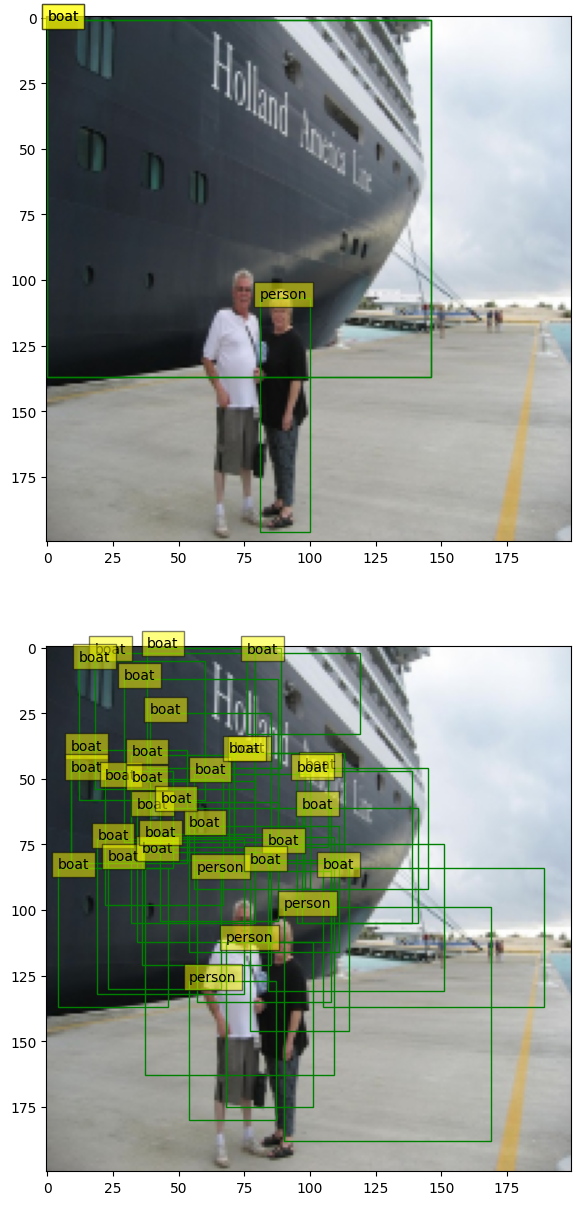

In [44]:
fig3, axes3 = plt.subplots(2, 1, figsize=(30, 15))
display_img([img_data_sample[0] , img_data_sample[0]], fig3, axes3)
display_boundingbox(gt_appear_in_an_img, [idx2name[int(i)] for i in gt_classes_sample[0][torch.where(gt_classes_sample[0] != -1)]], fig3, axes3[0])
display_boundingbox(proposals1.detach(), [idx2name[int(i)] for i in gt_classes1], fig3, axes3[1])